<a href="https://colab.research.google.com/github/napongps/Muaythai-comparison/blob/main/Muaythai_comparison_%5BCurrent%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def in_colab():
    from IPython.core import getipython
    return 'google.colab' in str(getipython.get_ipython())


in_colab()

True

In [2]:
if in_colab():
    !pip install mediapipe
    !pip install opencv-python
    !pip install pyshine
    !pip install plotly
    !pip install wget
# else:
#     %autosave 60
#     %pip install --upgrade ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 38.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a7bd15ab8f51f5dfb553f33042787809eb1b9bea1f24215e1e83369528457796
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
if in_colab():
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import math
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pyshine as ps
from glob import glob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Warning! PortAudio library not found
Warning! No module named 'keras.layers.convolutional'


In [5]:
mp_pose = mp.solutions.pose

pose_video = mp_pose.Pose(static_image_mode=False,
                          min_detection_confidence=0.5, model_complexity=2)

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [6]:
resource = 'C:\\Users\\Gear\Desktop\\resource'
friends_video = 'C:\\Users\\Gear\\Desktop\\resource\\Video เพื่อน'
diff_angle = 'C:\\Users\\Gear\\Desktop\\resource\\Different camera angle'
slash = '\\'
desktop = 'C:\\Users\\Gear\Desktop'
if in_colab():
    resource = '/content/drive/MyDrive/Resources'
    friends_video = '/content/drive/MyDrive/Resources/Video_เพื่อน'
    diff_angle = '/content/drive/MyDrive/Resources/Different camera angle'
    slash = '/'
    desktop = '/content'

# Landmark detection

In [7]:
def detectPose(frame: np.array):
    """
    Input:
        frame = numpy array of frame that is extracted by cv2

    Output:
        output_image = image that has skeleton in that frame
        norm_landmarks = camera coordinate every keypoint in that frame
        norm_world_landmarks = world coordinate every keypoint in that frame
    """

    output_image = frame.copy()
    output_image.flags.writeable = False
    result = pose_video.process(output_image)

    output_image.flags.writeable = True
    if result.pose_landmarks:
        norm_landmarks = result.pose_landmarks.landmark  # camera coordinate
        norm_world_landmarks = result.pose_world_landmarks.landmark  # world coordinate

        # เอา landmark ที่ไม่ได้ใช้ออก ใบหน้า นิ้วต่างๆ
        exclude_lndmk = list(range(11))
        exclude_lndmk.extend([29, 30, 17, 18, 21, 22])

        for i in exclude_lndmk:
            norm_landmarks[i].visibility = 0

        mp_drawing.draw_landmarks(image=output_image,
                                  landmark_list=result.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    return output_image, norm_landmarks, norm_world_landmarks

In [8]:
def formatJoint(landmarks_obj: list):
    """
    Input:
        landmarks_obj = result landmarks that get from mediapipe

    Output:
        list of x,z,y coordinate for every keypoint eg. [[x1, y1, z1], [x2, y1, z1], ..., [x33, y33, z33]]
    """

    return list(map(lambda ladk: [ladk.x, ladk.y, ladk.z], landmarks_obj))

In [9]:
def landmark_detection(path_vid: str):
    """
    Input:
        path_vid = path of video

    Output:
        cam_ladk = numpy array that contain camera coordinate of all keypoint in every frame of the video
        world_ladk = numpy array that contain world coordinate of all keypoint in every frame of the video
        all_frame = list that contain all skeletal frame in the video
    """

    video = cv2.VideoCapture(path_vid)

    all_frame = []
    cam_ladk = []
    world_ladk = []
    count = 0

    while video.isOpened():

        ret, frame = video.read()

        if not ret:
            break

        # กรณีที่ mediapipe ไม่สามารถหา landmark ได้ detectPose จะเป็น Nonetype
        try:
            output_image, norm_landmarks, norm_world_landmarks = detectPose(
                frame)
        except:
            continue

        output_image = ps.putBText(output_image, "Frame: {}".format(count),
                                   text_offset_x=50, text_offset_y=50, vspace=10, hspace=10,
                                   font_scale=1, background_RGB=(0, 0, 0), text_RGB=(255, 250, 250))

        all_frame.append(output_image)
        cam_ladk.append(formatJoint(norm_landmarks))
        world_ladk.append(formatJoint(norm_world_landmarks))

        count += 1

    video.release()
    cv2.destroyAllWindows()
    return np.array(cam_ladk), np.array(world_ladk), all_frame

# Export files

cannot use in jupyter nb

In [10]:
def export_ladk(path_des: str):
    """
    Input:
        path_des = A path of folder that contains videos
    """
    !rm -rf "/content/landmarks"
    !mkdir "/content/landmarks"
    vid_list = glob('/content/drive/MyDrive/Resources/Different camera angle/**/*.mp4')+glob('/content/drive/MyDrive/Resources/Different camera angle/**/*.MOV')
    for vid in vid_list:
        movement_name = vid.split('/')[-2]
        vid_name = vid.split('/')[-1].replace('.mp4','').replace('.MOV','')

        if not os.path.isdir("/content/landmarks/{}".format(vid.split('/')[-2])):
            !mkdir "/content/landmarks/{movement_name}"

        !mkdir "/content/landmarks/{movement_name}/{vid_name}"

        cam_ladk, world_ladk, all_frame = landmark_detection(vid)

        dir = '/content/landmarks/{}/{}'.format(movement_name, vid_name)
        with open("{}/cam_{}".format(dir, vid_name), "wb") as fp:
            np.save(fp, cam_ladk)
        with open("{}/world_{}".format(dir, vid_name), "wb") as fp:
            np.save(fp, world_ladk)
        with open("{}/all_frame_{}".format(dir, vid_name), "wb") as fp:
            pickle.dump(all_frame, fp)

    if os.path.isdir("{}/landmarks".format(path_des)):
        !rm -rf "{path_des}/landmarks"

    !rsync -a -q "/content/landmarks" "{path_des}"

In [11]:
# export_ladk('/content/drive/MyDrive/Resources/Video_เพื่อน')

In [12]:
# export_ladk('/content/drive/MyDrive/Resources/Different camera angle')

# Import files

In [13]:
def import_file(path: str):
    """
    Input:
        path = path of video landmark

    Output:
        cam_ladk = numpy array that contain camera coordinate of all keypoint in every frame of the video
        world_ladk = numpy array that contain world coordinate of all keypoint in every frame of the video
        all_frame = list that contain all skeletal frame in the video
    """

    vid_name = path.split(slash)[-1]
    with open('{}{}cam_{}'.format(path, slash, vid_name), 'rb') as f:
        cam_ladk = np.load(f, allow_pickle=True)
    with open('{}{}world_{}'.format(path, slash, vid_name), 'rb') as f:
        world_ladk = np.load(f, allow_pickle=True)
    with open("{}{}all_frame_{}".format(path, slash, vid_name), "rb") as fp:
        all_frame = pickle.load(fp)

    return cam_ladk, world_ladk, all_frame

In [14]:
cam_ladk_test, world_ladk_test, all_frame_test = import_file(friends_video + "{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า".format(slash, slash, slash))
cam_ladk_test2, world_ladk_test2, all_frame_test2 = import_file(friends_video + "{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า_2".format(slash, slash, slash))

# Import weight

In [15]:
def gen_weight_csv(similarity_function):

    if "angle" in similarity_function.__name__.lower():

        cols = ['r_wrist', 'r_elbow', 'r_shoulder', 'r_hip', 'r_knee', 'r_ankle',
                'l_wrist', 'l_elbow', 'l_shoulder', 'l_hip', 'l_knee', 'l_ankle']

    elif "cosine" in similarity_function.__name__.lower():

        cols = ['R_findex_ankle', 'R_ankle_knee', 'R_knee_hip', 'R_hip_shoulder', 'R_index_wrist', 'R_wrist_elbow', 'R_elbow_shoulder',
                'L_findex_ankle', 'L_ankle_knee', 'L_knee_hip', 'L_hip_shoulder', 'L_index_wrist', 'L_wrist_elbow', 'L_elbow_shoulder',
                'lshoulder_rshoulder', 'lhip_rhip']
    weight_dict = dict.fromkeys(cols, 1)

    path = 'C:\\Users\\Gear\Desktop\\resource\\weight_config_{}.csv'

    if in_colab():
        path = 'weight_config_{}.csv'

    pd.DataFrame(weight_dict, index=[0]).to_csv(
        path.format(similarity_function.__name__.lower()))

In [16]:
def import_weight(weight_csv: str, vid_name: str):
    df = pd.read_csv(weight_csv, encoding='utf-8')
    return df[df['Name'] == vid_name].to_numpy()[0][1:]

In [17]:
weight_angle = import_weight(resource + '{}weight_config_angle_list.csv'.format(slash), 'default')
weight_cosine = import_weight(resource + '{}weight_config_cosine_list.csv'.format(slash), 'default')

In [18]:
weight_angle

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=object)

In [19]:
import_weight(resource + '{}weight_config_cosine_list.csv'.format(slash), 'เข่าตรงหลัง')

array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2], dtype=object)

# Comparison methods

## Mapping score function

<ipython-input-20-d38f3ff8c76c>:11: RuntimeWarning: divide by zero encountered in divide
  y = np.where((x >= 0) & (x <= 1), 1/(1+(x/(1-x))**-2), x)
<ipython-input-20-d38f3ff8c76c>:11: RuntimeWarning: divide by zero encountered in power
  y = np.where((x >= 0) & (x <= 1), 1/(1+(x/(1-x))**-2), x)


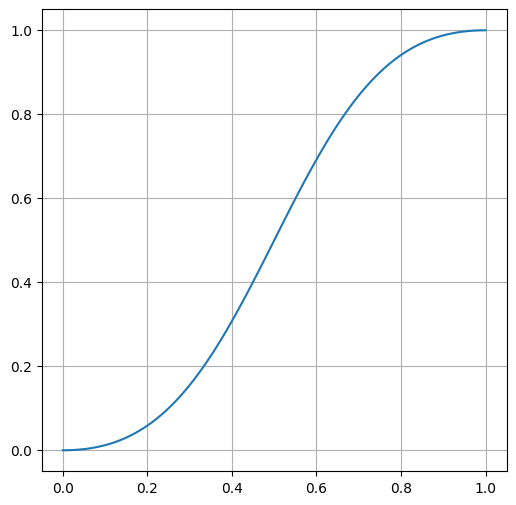

In [20]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 100)

# scaling here
# y = np.sign(x) * ((np.abs(x)) ** (3*1.4)) # formula = x^3z
# y = np.where(x>=0, np.where(x >= 0.5, np.cbrt(x), 5.65*x**3), np.cbrt(x))
# y = x**3
# y = np.cbrt(x)
y = np.where((x >= 0) & (x <= 1), 1/(1+(x/(1-x))**-2), x)

plt.figure(figsize=(6, 6))
# for i,j in zip(x,y):
#     print(i,j)
#     plt.annotate('({:.2f},{:.2f})'.format(i,j),xy=(i,j))
plt.plot(x, y)
plt.grid()
plt.show()

## Angle

### Extract function

In [21]:
def cal_norm_vec(point1: np.array, point2: np.array):

    vec = point2-point1
    vec_mag = np.linalg.norm(vec, axis=1)
    vec_norm = np.array(list(map((lambda x, y: x/y), vec, vec_mag)))

    return vec_norm

In [22]:
def cal_local_angle(point1: np.array, point2: np.array, point3: np.array):

    dot_result = np.sum(cal_norm_vec(point1, point2) *
                        cal_norm_vec(point3, point2), axis=1)
    angle = np.rad2deg(np.arccos(dot_result))

    return angle

In [23]:
def find_angle(world_ladk_vid: np.array):

    r_wrist = cal_local_angle(
        world_ladk_vid[:, 20], world_ladk_vid[:, 16], world_ladk_vid[:, 14])
    r_elbow = cal_local_angle(
        world_ladk_vid[:, 16], world_ladk_vid[:, 14], world_ladk_vid[:, 12])
    r_shoulder = cal_local_angle(
        world_ladk_vid[:, 14], world_ladk_vid[:, 12], world_ladk_vid[:, 24])
    r_hip = cal_local_angle(
        world_ladk_vid[:, 12], world_ladk_vid[:, 24], world_ladk_vid[:, 26])
    r_knee = cal_local_angle(
        world_ladk_vid[:, 24], world_ladk_vid[:, 26], world_ladk_vid[:, 28])
    r_ankle = cal_local_angle(
        world_ladk_vid[:, 26], world_ladk_vid[:, 28], world_ladk_vid[:, 32])

    l_wrist = cal_local_angle(
        world_ladk_vid[:, 19], world_ladk_vid[:, 15], world_ladk_vid[:, 13])
    l_elbow = cal_local_angle(
        world_ladk_vid[:, 15], world_ladk_vid[:, 13], world_ladk_vid[:, 11])
    l_shoulder = cal_local_angle(
        world_ladk_vid[:, 13], world_ladk_vid[:, 11], world_ladk_vid[:, 23])
    l_hip = cal_local_angle(
        world_ladk_vid[:, 11], world_ladk_vid[:, 23], world_ladk_vid[:, 25])
    l_knee = cal_local_angle(
        world_ladk_vid[:, 23], world_ladk_vid[:, 25], world_ladk_vid[:, 27])
    l_ankle = cal_local_angle(
        world_ladk_vid[:, 25], world_ladk_vid[:, 27], world_ladk_vid[:, 31])

    return np.array([r_wrist, r_elbow, r_shoulder, r_hip, r_knee, r_ankle,
                    l_wrist, l_elbow, l_shoulder, l_hip, l_knee, l_ankle]).T

In [24]:
angle_vid1 = find_angle(world_ladk_test)

In [25]:
angle_vid2 = find_angle(world_ladk_test2)

### Similarity

In [26]:
def angle_similarity(ang1: np.array, ang2: np.array, weight: np.array, max_angle: int, expo: bool):
    """
    คำนวณความเหมือนกันของมุมในแต่ละข้อพับระหว่าง 2 วิดิโอ (0 - max_angle)

    input:
        ang1 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 1 ได้จาก find_angle
        ang2 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 2 ได้จาก find_angle
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight
        max_angle : ค่าที่ใช้ในการ normalize แต่ละมุมข้อพับ

    output:
        numpy array ความเหมือนของมุมข้อพับ 12 มุมที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """

    joint_diff_norm = max_angle-(np.abs(ang1 - ang2) / max_angle)

    if not expo:
        return joint_diff_norm * weight
    else:
        joint_diff_expo = np.where((joint_diff_norm >= 0) & (
            joint_diff_norm <= 1), 1/(1+(joint_diff_norm/(1-joint_diff_norm))**-2), joint_diff_norm)
        # each angle has range between 0 and 1 (default weight)
        return joint_diff_expo * weight

###Difference

In [27]:
def angle_difference(ang1: np.array, ang2: np.array, weight: np.array, max_angle: int, expo: bool):
    """
    คำนวณความต่างของมุมในแต่ละข้อพับระหว่าง 2 วิดิโอ (0 - max_angle)

    input:
        ang1 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 1 ได้จาก find_angle
        ang2 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 2 ได้จาก find_angle
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight
        max_angle : ค่าที่ใช้ในการ normalize แต่ละมุมข้อพับ

    output:
        numpy array ความต่างของมุมข้อพับ 12 มุมที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """

    joint_diff_norm = (np.abs(ang1 - ang2) / max_angle)

    if not expo:
        return joint_diff_norm * weight
    else:
        joint_diff_expo = np.where((joint_diff_norm >= 0) & (
            joint_diff_norm <= 1), 1/(1+(joint_diff_norm/(1-joint_diff_norm))**-2), joint_diff_norm)
        # each angle has range between 0 and 1 (default weight)
        return joint_diff_expo * weight

## Cosine

### Extract function

In [28]:
def find_limb(world_ladk_vid: np.array):
    """
    Output:
        result[limb][frame][coordinate]
    """

    R_findex_ankle = world_ladk_vid[:, 32] - world_ladk_vid[:, 28]
    R_ankle_knee = world_ladk_vid[:, 28] - world_ladk_vid[:, 26]
    R_knee_hip = world_ladk_vid[:, 26] - world_ladk_vid[:, 24]
    R_hip_shoulder = world_ladk_vid[:, 24] - world_ladk_vid[:, 12]
    R_index_wrist = world_ladk_vid[:, 20] - world_ladk_vid[:, 16]
    R_wrist_elbow = world_ladk_vid[:, 16] - world_ladk_vid[:, 14]
    R_elbow_shoulder = world_ladk_vid[:, 14] - world_ladk_vid[:, 12]

    L_findex_ankle = world_ladk_vid[:, 31] - world_ladk_vid[:, 27]
    L_ankle_knee = world_ladk_vid[:, 27] - world_ladk_vid[:, 25]
    L_knee_hip = world_ladk_vid[:, 25] - world_ladk_vid[:, 23]
    L_hip_shoulder = world_ladk_vid[:, 23] - world_ladk_vid[:, 11]
    L_index_wrist = world_ladk_vid[:, 19] - world_ladk_vid[:, 15]
    L_wrist_elbow = world_ladk_vid[:, 15] - world_ladk_vid[:, 13]
    L_elbow_shoulder = world_ladk_vid[:, 13] - world_ladk_vid[:, 11]

    lshoulder_rshoulder = world_ladk_vid[:, 11] - world_ladk_vid[:, 12]
    lhip_rhip = world_ladk_vid[:, 23] - world_ladk_vid[:, 24]

    return np.array([R_findex_ankle, R_ankle_knee, R_knee_hip, R_hip_shoulder, R_index_wrist, R_wrist_elbow, R_elbow_shoulder,
                     L_findex_ankle, L_ankle_knee, L_knee_hip, L_hip_shoulder, L_index_wrist, L_wrist_elbow, L_elbow_shoulder,
                     lshoulder_rshoulder, lhip_rhip]).transpose(1, 0, 2)

In [29]:
limb_vid1 = find_limb(world_ladk_test)

In [30]:
limb_vid2 = find_limb(world_ladk_test2)

### Similarity

In [31]:
def cosine_similarity(vec1: np.array, vec2: np.array, weight: np.array, min_cosine_sim: int, expo: bool):
    """
    คำนวณความเหมือนด้วย cosine similarity (min_cosine_sim - 1)
    K(X, Y) = X dot Y / (||X||*||Y||)

    input:
        vec1: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 1 ได้จากฟังก์ชัน find_limb
        vec2: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 2 ได้จากฟังก์ชัน find_limb
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight
        min_cosine_sim: ค่าที่ใช้การ normalize แต่ละท่อนแขนท่อนขา รับเข้ามาเป็นองศา

    output:
         numpy array ความเหมือนของเวกเตอร์ 16 ท่อนที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """
    # 180 คือ -1, 90 คือ 0, 45 คือ sqrt(2)/2
    min_cosine_sim = np.cos(np.radians(min_cosine_sim))

    limb_diff_norm = (((np.sum(vec1*vec2, axis=1)/(np.linalg.norm(vec1, axis=1)
                      * np.linalg.norm(vec2, axis=1)))-min_cosine_sim)/(1-min_cosine_sim))

    if not expo:
        return limb_diff_norm * weight
    else:
        limb_diff_expo = np.where((limb_diff_norm >= 0) & (
            limb_diff_norm <= 1), 1/(1+(limb_diff_norm/(1-limb_diff_norm))**-2), limb_diff_norm)
        # each limb has range between 0 and 1 (default weight)
        return limb_diff_expo * weight

### Difference

In [32]:
def cosine_difference(vec1: np.array, vec2: np.array, weight: np.array, max_cosine_diff: int, expo: bool):
    """
    คำนวณความต่างด้วย 1 - cosine similarity (0 - max_cosine_diff)

    input:
        vec1: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 1 ได้จากฟังก์ชัน find_limb
        vec2: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 2 ได้จากฟังก์ชัน find_limb
        max_cosine_diff: ค่าที่ใช้การ normalize แต่ละท่อนแขนท่อนขา
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight

    output:
        numpy array ความต่างของเวกเตอร์ 16 ท่อนที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """

    # 180 คือ -1, 90 คือ 0, 45 คือ sqrt(2)/2
    max_cosine_diff = np.cos(np.radians(max_cosine_diff))

    limb_diff_norm = (1 - (np.sum(vec1*vec2, axis=1)/(np.linalg.norm(vec1,
                      axis=1)*np.linalg.norm(vec2, axis=1))))/(1-max_cosine_diff)

    if not expo:
        return limb_diff_norm * weight
    else:
        limb_diff_expo = np.where((limb_diff_norm >= 0) & (
            limb_diff_norm <= 1), 1/(1+(limb_diff_norm/(1-limb_diff_norm))**-2), limb_diff_norm)
        # each limb has range between 0 and 1 (default weight)
        return limb_diff_expo * weight

# Automatic weight

In [33]:
def diff_move(extracted_ladk: np.array, windows: int, curr_frame: int, max_angle: int, method='aj'):

    if method.lower() == 'aj':
        if extracted_ladk.shape[1] == 12:
            adj_diff = angle_difference(ang1=extracted_ladk[curr_frame],
                                        ang2=extracted_ladk[curr_frame-1],
                                        weight=np.ones(12),
                                        max_angle=max_angle,
                                        expo=False)

        if extracted_ladk.shape[1] == 16:
            adj_diff = cosine_difference(vec1=extracted_ladk[curr_frame],
                                         vec2=extracted_ladk[curr_frame-1],
                                         weight=np.ones(16),
                                         max_cosine_diff=max_angle,
                                         expo=False)

        return adj_diff

    elif method.lower() == 'me':
        if extracted_ladk.shape[1] == 12:
            prev_diff = np.abs(
                extracted_ladk[curr_frame] - extracted_ladk[curr_frame-windows:curr_frame])/max_angle
            next_diff = np.abs(
                extracted_ladk[curr_frame] - extracted_ladk[curr_frame+1:curr_frame+windows+1])/max_angle

            total_diff = np.append(prev_diff, next_diff, axis=0)
            mean_total_diff = np.mean(total_diff, axis=0)

        if extracted_ladk.shape[1] == 16:
            max_cosine_diff = np.cos(np.radians(max_angle))
            prev_diff = (1 - (np.sum(extracted_ladk[curr_frame][np.newaxis, :] * extracted_ladk[curr_frame-windows:curr_frame], axis=2) / (np.linalg.norm(
                extracted_ladk[curr_frame][np.newaxis, :], axis=2) * np.linalg.norm(extracted_ladk[curr_frame-windows:curr_frame], axis=2))))/(1-max_cosine_diff)
            next_diff = (1 - (np.sum(extracted_ladk[curr_frame][np.newaxis, :] * extracted_ladk[curr_frame+1:curr_frame+windows+1], axis=2) / (np.linalg.norm(
                extracted_ladk[curr_frame][np.newaxis, :], axis=2) * np.linalg.norm(extracted_ladk[curr_frame+1:curr_frame+windows+1], axis=2))))/(1-max_cosine_diff)

            mean_total_diff_temp = np.stack((prev_diff.T, next_diff.T), axis=1)

            mean_total_diff = np.mean(
                np.mean(mean_total_diff_temp, axis=1), axis=1)

        return mean_total_diff+1

In [34]:
def MA_W(extracted_ladk: np.array, windows: int, max_angle=180, method='aj'):

    frame = extracted_ladk.shape[0]

    if (windows+windows) > frame:
        frame_diff = (windows+windows) - frame
        extracted_ladk = np.insert(
            extracted_ladk, 0, [extracted_ladk[0]]*(math.ceil(frame_diff/2)+1), axis=0)
        extracted_ladk = np.insert(
            extracted_ladk, -1, [extracted_ladk[-1]]*(math.ceil(frame_diff/2)+1), axis=0)
        frame = extracted_ladk.shape[0]

    # adjacent frame diff
    if method.lower() == 'aj':

        all_adj_diff = []
        for curr_frame in range(1, frame):
            all_adj_diff.append(diff_move(extracted_ladk=extracted_ladk,
                                          windows=windows,
                                          curr_frame=curr_frame,
                                          max_angle=max_angle,
                                          method=method.lower()))

        all_adj_diff.append(all_adj_diff[-1])
        all_adj_diff = np.array(all_adj_diff)

        # sliding window
        all_weight = []
        for curr_frame in range(windows, frame-windows+1):
            forward_dist = np.sum(
                all_adj_diff[curr_frame:curr_frame+windows+1], axis=0)
            backward_dist = np.sum(
                all_adj_diff[curr_frame-windows:curr_frame], axis=0)
            total_dist = (forward_dist+backward_dist)
            all_weight.append(total_dist)

        all_weight = np.array(all_weight)
        all_weight = (all_weight/windows)+1

    # diff between f frame and frames in window
    elif method.lower() == 'me':

        # sliding window
        all_weight = []
        for curr_frame in range(windows, frame-windows+1):

            weight_by_frame = diff_move(extracted_ladk=extracted_ladk,
                                        windows=windows,
                                        curr_frame=curr_frame,
                                        max_angle=max_angle,
                                        method=method.lower())
            all_weight.append(weight_by_frame)

        all_weight = np.array(all_weight)

    # add first n frame to all_weight
    all_weight = np.insert(all_weight, 0, [all_weight[0]]*windows, axis=0)

    # add last n frame to all_weight
    all_weight = np.insert(all_weight, -1, [all_weight[-1]]*windows, axis=0)

    return all_weight

In [35]:
all_weight = MA_W(limb_vid1, 30, 45, 'aj')

# DTW

กรณีที่วิดิโอที่ 1 สั้นกว่าวิดิโอที่ 2 อาจ error ได้

In [36]:
def dm(extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, sim_diff_function,
       weight, norm_value: int, windows: int, method='aj', expo=False):

    N = extracted_ladk_vid1.shape[0]
    M = extracted_ladk_vid2.shape[0]

    dist_mat = np.zeros((N, M))
    dist_ladk_mat = np.zeros((N, M), dtype=object)

    if isinstance(weight, str):
        if weight.lower() == 'auto':
            weight = MA_W(extracted_ladk_vid1, windows, norm_value, method)
    else:
        weight = [weight]*max(N, M)

    for i in range(N):
        for j in range(M):

            dist_ladk_mat[i, j] = sim_diff_function(
                extracted_ladk_vid1[i], extracted_ladk_vid2[j], weight[i], norm_value, expo)
            dist_mat[i, j] = np.sum(dist_ladk_mat[i, j]) / \
                np.sum(weight[i])  # 0-1 (Default weight)

    return dist_ladk_mat, dist_mat

In [37]:
dist_ladk_mat_test, dist_mat_test = dm(limb_vid1, limb_vid2, cosine_similarity, weight_cosine, 180, 25)

In [38]:
def dp(dist_mat: np.array, mode: str):
    """
    ขวาล่าง-ซ้ายบน (cost)
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape

    # Initialize the cost matrix
    cost_mat = np.zeros((N, M))
    if 'difference' in mode:
        cost_mat = np.insert(cost_mat, 0, np.inf, axis=1)
        cost_mat = np.insert(cost_mat, 0, np.inf, axis=0)
    elif 'similarity' in mode:
        cost_mat = np.insert(cost_mat, 0, -np.inf, axis=1)
        cost_mat = np.insert(cost_mat, 0, -np.inf, axis=0)
    cost_mat[0, 0] = 0

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M), dtype='uint8')
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            if 'difference' in mode:
                i_penalty = np.argmin(penalty)
            elif 'similarity' in mode:
                i_penalty = np.argmax(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    vert_hor = 0

    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]

        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1

        elif tb_type == 1:
            # Insertion
            i = i - 1
            vert_hor += 1

        elif tb_type == 2:
            # Deletion
            j = j - 1
            vert_hor += 1

        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    cost_mat = cost_mat/len(path)

    return path[::-1], cost_mat, vert_hor

In [39]:
path_dp, cost_mat_dp, vert_hor_dp = dp(dist_mat_test, 'cosine_similarity')

In [40]:
def unique_path(path):
    new_path = []
    temp_i = None
    temp_j = None
    for i, j in path:
        if (i == temp_i) or (j == temp_j):
            continue
        temp_i = i
        temp_j = j
        new_path.append((i, j))
    return np.array(new_path)

In [41]:
def dtw(name_vid1: str, name_vid2: str, extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, sim_diff_function,
        path_finder, weight, norm_value=180, windows=50, thresh=False, MAW_method='aj', expo=False):

    dist_lndmk_mat, dist_mat = dm(extracted_ladk_vid1=extracted_ladk_vid1,
                                  extracted_ladk_vid2=extracted_ladk_vid2,
                                  sim_diff_function=sim_diff_function,
                                  weight=weight,
                                  norm_value=norm_value,
                                  windows=windows,
                                  method=MAW_method,
                                  expo=expo)

    path, cost_mat, vert_hor = path_finder(dist_mat=dist_mat,
                                           mode=sim_diff_function.__name__)

    row = np.array(path)[:, 0]
    col = np.array(path)[:, 1]
    dist_mat_path = dist_mat[row, col]

    unique_row = unique_path(path)[:, 0]
    unique_col = unique_path(path)[:, 1]
    dist_mat_unique = dist_mat[unique_row, unique_col]

    frames_count = dist_mat_unique.shape[0]

    if 'difference' in sim_diff_function.__name__:
        dist_mat_path = 1-dist_mat_path
        dist_mat_unique = 1-dist_mat_unique

    cost = np.sum(dist_mat_path)/len(path)
    std_all = np.std(dist_mat_path, dtype=np.float32)
    std_unique = np.std(dist_mat_unique, dtype=np.float32)
    mean = np.mean(dist_mat_path, dtype=np.float32)

    if thresh:
        thresh = np.mean(dist_mat_path)-0.03
        cost = np.sum(dist_mat_path[dist_mat_path > thresh])/len(path)

    df1 = pd.DataFrame({'Unique_frames':list(unique_path(all_path)), 'Sim_score':list(dist_mat_unique)})
    df1.to_csv("{}{}dtw_{}_{}_{}{}dtw_{}_{}_{}_{}{}{}{}{}{}{}.csv".format(desktop+slash+'dtw', slash, name_vid1, name_vid2, sim_diff_function.__name__,
                                                              slash, name_vid1, name_vid2, sim_diff_function.__name__, path_finder.__name__,
                                                             weight_name,window,maw_met_name,expo_name,thresh_name,keyframe_name))

    return None, None, path, dist_mat, dist_lndmk_mat, cost_mat, vert_hor, cost, [std_all, std_unique, mean, frames_count]

In [42]:
!mkdir "{desktop}{slash}dtw"

In [43]:
# keyframes_list, student_kf, path_test, dist_mat_test, dist_lndmk_mat_test, cost_mat_test, vert_hor_test, cost_test, stats = dtw('vid1','vid2',limb_vid1, limb_vid2, cosine_similarity, dp, 'auto', 90, 60, True, 'aj')

In [44]:
# keyframes_list, student_kf, path_test, dist_mat_test, dist_lndmk_mat_test, cost_mat_test, vert_hor_test, cost_test, stats = dtw('vid1', 'vid2', limb_vid1, limb_vid2, cosine_difference, dp, 'auto', 90, 60, False, 'aj')

# Find keyframes

In [45]:
def video_to_img(path):
    vid = cv2.VideoCapture(path)
    vid_name = path.split(slash)[-1].replace('.mp4','')
    !mkdir "{desktop}{slash}img{slash}{vid_name}"
    count = 0
    while vid.isOpened():

        ret, frame = vid.read()

        if not ret:
            break

        cv2.imwrite("{}{}img{}{}{}{}_{}.jpg".format(desktop, slash, slash, vid_name, slash, vid_name,count), frame)

        count += 1

    vid.release()
    cv2.destroyAllWindows()

In [46]:
# !mkdir '{desktop}{slash}img'
# for p in glob('/content/drive/MyDrive/Resources/Video_เพื่อน/**/**.mp4'):
#     video_to_img(p)

In [47]:
# !mkdir '{desktop}{slash}img'
# for p in glob('/content/drive/MyDrive/Resources/Different camera angle/**/**.mp4'):
#     # video_to_img(p)
#     print(p)

## Find matching keyframe

In [48]:
def match_kf(keyframe: int, dist_mat: np.array, prev_frame: int):
    # print('keyframe',keyframe, 'prev_frame',prev_frame)
    vid_len = dist_mat[prev_frame:].shape[0]
    half_frame = math.ceil(vid_len/2)+prev_frame
    # print(vid_len,half_frame)
    # print('prev_frame',prev_frame,'half_frame',half_frame)
    # print('min_score',np.min(dist_mat[keyframe, prev_frame:half_frame]))
    return prev_frame + np.where(dist_mat[keyframe, prev_frame:half_frame] == np.max(dist_mat[keyframe, prev_frame:half_frame]))[0][0]

In [49]:
dist_lndmk_mat, dist_mat = dm(limb_vid1, limb_vid2, cosine_similarity, weight_cosine, 45, 30)

In [50]:
keyframes_list=[106, 186, 214]
student_kf = []

temp_kf = match_kf(keyframes_list[0], dist_mat, 0)
print(keyframes_list[0], temp_kf)
student_kf.append(temp_kf)

for kf in keyframes_list[1:]:
    temp_kf = match_kf(kf, dist_mat, temp_kf)
    print(kf, temp_kf)
    student_kf.append(temp_kf)

print(keyframes_list)
print(student_kf)

106 89
186 145
214 163
[106, 186, 214]
[89, 145, 163]


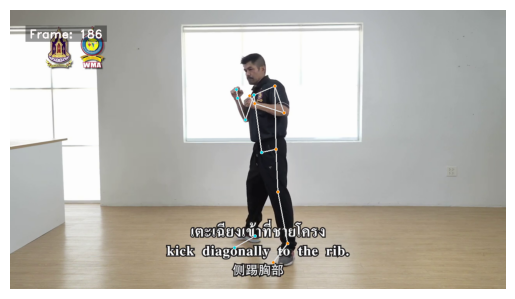

In [51]:
plt.axis(False)
plt.imshow(all_frame_test[186][:,:,::-1])
plt.savefig('test.png',bbox_inches='tight')

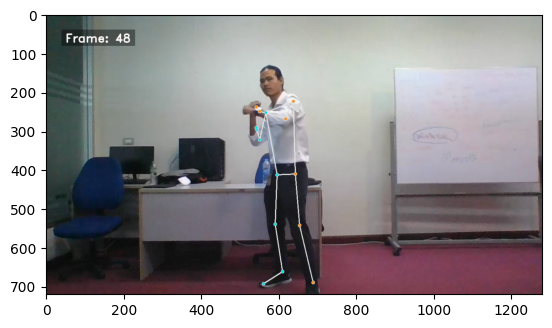

In [52]:
plt.imshow(all_frame_test2[48][:,:,::-1])

In [53]:
def dtw_keyframe(name_vid1: str, name_vid2: str, extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, keyframes_list: list, sim_diff_function, path_finder, weight,
                 norm_value=180, windows=50, thresh=False, MAW_method='aj', expo=False):

    thresh_name=''
    expo_name=''
    keyframe_name=''

    if 2 in set(weight):
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if isinstance(weight, float):
        weight_name = '-MAW'
    else:
        window = ''

    if thresh:
        thresh_name = '-thresh'

    if expo:
        expo_name = '-expo'

    if MAW_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframes_list != []:
        keyframe_name = '-keyframe'

    if keyframes_list == []:
        return dtw(name_vid1,
                   name_vid2,
                   extracted_ladk_vid1=extracted_ladk_vid1,
                   extracted_ladk_vid2=extracted_ladk_vid2,
                   sim_diff_function=sim_diff_function,
                   path_finder=path_finder,
                   weight=weight,
                   norm_value=norm_value,
                   windows=windows,
                   thresh=thresh,
                   MAW_method=MAW_method,
                   expo=expo)

    dist_lndmk_mat, dist_mat = dm(extracted_ladk_vid1=extracted_ladk_vid1,
                                  extracted_ladk_vid2=extracted_ladk_vid2,
                                  sim_diff_function=sim_diff_function,
                                  weight=weight,
                                  norm_value=norm_value,
                                  windows=windows,
                                  method=MAW_method,
                                  expo=expo)

    if 'difference' in sim_diff_function.__name__:
        dist_mat = 1-dist_mat

    student_kf = []
    prev_match_frame = match_kf(keyframes_list[0], dist_mat, 0)
    student_kf.append(prev_match_frame)
#     print(keyframes_list[0], prev_match_frame)

    for kf in keyframes_list[1:]:
        prev_match_frame = match_kf(kf, dist_mat, prev_match_frame)
        student_kf.append(prev_match_frame)
#         print(kf, prev_match_frame)

    all_vert_hor = 0
    all_row = np.array([], dtype=np.uint16).reshape(0, 1)
    all_col = np.array([], dtype=np.uint16).reshape(0, 1)
    # print(keyframes_list)
    # print(student_kf)

    for ks, ke, stks, stke in list(zip(keyframes_list, keyframes_list[1:], student_kf, student_kf[1:])):

        # print('ks:',ks, 'ke:',ke, 'stks:',stks, 'stke:',stke)
        # print('dist_mat shape:', dist_mat[ks:ke+1,stks:stke+1].shape)
        path, cost_mat, vert_hor = path_finder(
            dist_mat[ks:ke+1, stks:stke+1], sim_diff_function.__name__)

        row = (np.asarray(path)+ks)[:, 0].reshape(-1, 1)
        col = (np.asarray(path)+stks)[:, 1].reshape(-1, 1)

        all_row = np.vstack((all_row, row))
        all_col = np.vstack((all_col, col))

        all_vert_hor += vert_hor

    all_path = np.unique(np.hstack((all_row, all_col)), axis=0)

    dist_mat_path = dist_mat[all_path[:, 0], all_path[:, 1]]
    dist_mat_unique = dist_mat[unique_path(
        all_path)[:, 0], unique_path(all_path)[:, 1]]
    unique_frames_count = dist_mat_unique.shape[0]

    cost = np.mean(dist_mat_path)
    std_all = np.std(dist_mat_path, dtype=np.float32)
    std_unique = np.std(dist_mat_unique, dtype=np.float32)
    mean = np.mean(dist_mat_path, dtype=np.float32)

    if thresh:
        thresh = np.mean(dist_mat_path)-0.03
        cost = np.sum(dist_mat_path[dist_mat_path > thresh])/all_path.shape[0]

    df1 = pd.DataFrame({'Unique_frames':list(unique_path(all_path)), 'Sim_score':list(dist_mat_unique)})
    df1.to_csv("{}{}dtw_{}_{}_{}{}dtw_{}_{}_{}_{}{}{}{}{}{}{}.csv".format(desktop+slash+'dtw', slash, name_vid1, name_vid2, sim_diff_function.__name__,
                                                              slash, name_vid1, name_vid2, sim_diff_function.__name__, path_finder.__name__,
                                                             weight_name,window,maw_met_name,expo_name,thresh_name,keyframe_name))

    df2 = pd.DataFrame({'Teacher_kf': keyframes_list, 'Student_kf': student_kf,
                        'Sim_Score': dist_mat[np.array(keyframes_list), np.array(student_kf)]})
    df2.to_csv("{}{}dtw_{}_{}_{}{}dtw_{}_kf_{}_kf_{}_{}{}{}{}{}{}{}.csv".format(desktop+slash+'dtw', slash, name_vid1, name_vid2, sim_diff_function.__name__,
                                                                    slash, name_vid1, name_vid2, sim_diff_function.__name__, path_finder.__name__,
                                                                               weight_name,window,maw_met_name,expo_name,thresh_name,keyframe_name))

    return keyframes_list, student_kf, all_path, dist_mat, dist_lndmk_mat, cost_mat, all_vert_hor, cost, [std_all, std_unique, mean, unique_frames_count]

In [54]:
# keyframes_list, student_kf, all_path_kf, dist_mat_kf, dist_lndmk_mat_kf, cost_mat_kf, all_vert_hor_kf, cost_kf, stats_kf = dtw_keyframe('เตะเฉียงหน้า', 'เตะเฉียงหน้า_2', limb_vid1, limb_vid2, [106, 186, 214], cosine_similarity, dp, weight_cosine)

In [55]:
def save_kf_img(name_vid1, name_vid2, all_frame_vid1, all_frame_vid2, kf, stu_kf, des_path):

    !mkdir "{des_path}{slash}kf_img"

    for i,j in zip(kf, stu_kf):

        match_kf_img = cv2.hconcat([all_frame_vid1[i][:,:,::-1], all_frame_vid2[j][:,:,::-1]])
        plt.axis(False)
        plt.imshow(match_kf_img)
        plt.savefig('{}{}kf_img{}{}_{}_{}_{}'.format(des_path, slash, slash, name_vid1, name_vid2, i, j),bbox_inches='tight')

# Display

## Create legend

<ipython-input-56-a0703c0fbc08>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)


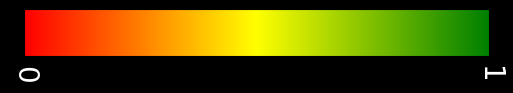

In [56]:
import matplotlib.colors


def color_legend():
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "", ["red", "yellow", "green"])
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))

    fig, ax = plt.subplots(1, figsize=(6, 2), facecolor='black')
    plt.tick_params(axis='x', labelcolor=[1, 1, 1])
    plt.tick_params(axis='x', labelsize=20)
    ax.get_yaxis().set_visible(False)
    ax.imshow([colors], extent=[0, 10, 0, 1])
    ax.set(xticks=([0, 10]))
    ax.set(xticklabels=([0, 1]))
    ax.tick_params(axis='x', labelrotation=-90)
    plt.savefig(resource + '{}color_legend.png'.format(slash),
                facecolor=fig.get_facecolor())
    return fig


cl = color_legend()

In [57]:
def add_cl(image, y, x, width_ratio, height_ratio, dist, sim_diff_function):

    cl = cv2.imread(resource + '{}color_legend.png'.format(slash))

    dim = (int(image.shape[0]*height_ratio), int(image.shape[1]*width_ratio))
    cl = cv2.resize(cl, dim)
    cl_img = cv2.rotate(cl, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cl_height, cl_width, _ = cl_img.shape

    if 'similarity' in sim_diff_function.__name__.lower():
        dist = 1 - dist

    dist_y = dist*cl_height

    start_point = (int(0.7*cl_width), int(0.1*cl_height))
    end_point = (int(cl_width-(0.7*cl_width)), int(int(0.1*cl_height)+dist_y))
    cv2.rectangle(cl_img, start_point, end_point, (0, 0, 0), -1)

    gray_cl = cv2.cvtColor(cl_img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_cl, 0, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    roi = image[y:y+cl_height, x:x+cl_width]
    img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
    result = cv2.add(img_bg, cl_img)
    image[y:y+cl_height, x:x+cl_width] = result

    alpha = 0.5
    beta = (1.0 - alpha)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    dst = cv2.addWeighted(
        image[y:y+cl_height, x:x+cl_width], alpha, mask, beta, 0.0)

    image[y:y+cl_height, x:x+cl_width] = dst

    ps.putBText(image, "Distance between frame",
                text_offset_x=10, text_offset_y=y-20, vspace=5, hspace=5,
                font_scale=0.5, background_RGB=(0, 0, 0), text_RGB=(255, 250, 250))

## Progress bar

In [58]:
def progressBar(image: np.array, dist: float, cost: float, sim_diff_function):
    """
    วาดหลอดแสดงค่าคะแนน แสดงเป็นค่าความเหมือน

    input:
        image : frame ภาพที่จะวาด
        dist : ค่าคะแนนความต่าง/ความเหมือนต่อเฟรม
        cost : ยอดสะสมค่าคะแนนความต่าง/ความเหมือน
        sim_diff_function : ฟังก์ชันที่ใช้ในการคำนวณความต่าง/ความเหมือน

    output:
        หลอดแนวตั้ง: แสดงค่าความเหมือนของวิดิโอทั้ง 2 ในคู่เฟรมนั้นๆ
        หลอดแนวนอน: แสดงค่าความเหมือนรวมกันตั้งแต่ต้นยันจบของ 2 วิดิโอ
    """
    height, width, _ = image.shape

    if 'difference' in sim_diff_function.__name__.lower():
        dist = 1 - dist
        cost = 1 - cost

    cv2.line(image, (0, height), (width, height), (255, 255, 255), 40)
    cv2.line(image, (0, height), (int(cost*width), height), (50, 205, 50), 40)
    cv2.putText(image, 'Total Similarity Score: ', (0, height), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(image, '{:.2f}'.format(cost*100), (int(cost*width)-35, height), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 0), 2, cv2.LINE_AA)

## Error point

In [59]:
def form_vec(coor_arr: np.array):
    """
    เอาเฉพาะ x กับ y ในตำแหน่งข้อต่อ

    input:
        coor_arr: ตำแหน่งข้อต่อ 3 มิติ (x,y,z)

    output:
        ตำแหน่งข้อต่อ 2 มิติ
    """
    return (int(coor_arr[0]), int(coor_arr[1]))

In [60]:
def denormalize_landmark(cam_landmark: np.array, mapped_landmark: list, width: int, height: int):
    """
    denormalize landmark

    input:
        cam_landmark : ตำแหน่งข้อต่อแบบ camera coordinate
        mapped_landmark : ตำแหน่ง landmark ที่ k ใน cam_landmark
        width : ความกว้างของรูป (x)
        height : ความสูงของรูป (y)

    output:
        denorm_landmark : denormalized landmark
    """

    denorm_landmark = []
    for i in mapped_landmark:
        denorm_landmark.append(
            [cam_landmark[i][0]*width, cam_landmark[i][1]*height, cam_landmark[i][2]*width])
    denorm_landmark.append(
        [cam_landmark[19][0]*width, cam_landmark[19][1]*height, cam_landmark[19][2]*width])
    denorm_landmark.append(
        [cam_landmark[20][0]*width, cam_landmark[20][1]*height, cam_landmark[20][2]*width])
    denorm_landmark.append(
        [cam_landmark[31][0]*width, cam_landmark[31][1]*height, cam_landmark[31][2]*width])
    denorm_landmark.append(
        [cam_landmark[32][0]*width, cam_landmark[32][1]*height, cam_landmark[32][2]*width])

    return denorm_landmark

In [61]:
def map_landmark(sim_diff_function, k: int):
    """
    ฟังก์ชัน map ตำแหน่งของข้อพับทั้ง 12 หรือท่อนแขนท่อนขาทั้ง 16 เป็นตำแหน่งใน cam_landmark

    input:
        sim_diff_function : ฟังก์ชันที่ใช้ในการคำนวณค่าคะแนน
        k : ข้อพับ/ท่อนแขนท่อนขาที่เท่าไหร่

    output:
        dict_map[k] : ตำแหน่งของข้อพับ/ท่อนแขนท่อนขาที่ k ใน cam_landmark
    """

    if "angle" in sim_diff_function.__name__.lower():
        dict_map = {0: [16], 1: [14], 2: [12], 3: [24], 4: [26], 5: [
            28], 6: [15], 7: [13], 8: [11], 9: [23], 10: [25], 11: [27]}
    elif "cosine" in sim_diff_function.__name__.lower():
        dict_map = {0: [28, 32], 1: [26, 28], 2: [24, 26], 3: [12, 24], 4: [16, 20], 5: [14, 16], 6: [12, 14], 7: [27, 31], 8: [25, 27], 9: [23, 25],
                    10: [11, 23], 11: [15, 19], 12: [13, 15], 13: [11, 13], 14: [11, 12], 15: [23, 24]}
    return dict_map[k]

In [62]:
def color_error(cam_landmark: np.array, width: int, height: int, image: np.array, dist_lndmk_mat: np.array, k: int,
                weight: np.array, sim_diff_function):
    """
    ฟังก์ชันแสดงจุดที่ผิดพลาด

    input:
        cam_landmark : ตำแหน่งข้อต่อแบบ camera coordinate
        width : ความกว้างของรูป (x)
        height : ความสูงของรูป (y)
        image : รูปภาพ frame ที่ต้องการ
        dist_lndmk_mat : ค่าคะนนความต่าง/ความเหมือน ของแต่ละข้อต่อ ของทุกคู่เฟรม (แยกข้อต่อ/แยกท่อนแขนท่อนขา)
        k : ข้อต่อ/ท่อนแขนท่อนขา ที่เท่าไหร่ใน dist_lndmk_mat
        weight : ค่าถ่วงน้ำหนักที่ได้จาก csv config
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน

    output:
        new_image : ภาพที่แสดงจุดผิดพลาดไป 1 ข้อต่อ/ท่อนแขนท่อนขา
    """

    annotated_img = image.copy()
    denorm_landmark = denormalize_landmark(
        cam_landmark, map_landmark(sim_diff_function, k), width, height)

    for i in range(len(denorm_landmark)):
        cv2.circle(image, (int(denorm_landmark[i][0]), int(
            denorm_landmark[i][1])), 4, (255, 255, 255), -1)

    # ori_similarity = (dist_lndmk_mat[k]/weight[k])
    ori_similarity = dist_lndmk_mat[k]

    if "angle" in sim_diff_function.__name__.lower():
        bright = ori_similarity*255
        size = int(max(5, min(20, 1/(ori_similarity))))

        cv2.circle(annotated_img, (int(denorm_landmark[0][0]), int(
            denorm_landmark[0][1])), size, (0, bright, 255), -1)

    elif "cosine" in sim_diff_function.__name__.lower():
        bright = ori_similarity*255
        size = int(max(3, min(20, 1/(ori_similarity))))

        cv2.line(annotated_img, form_vec(denorm_landmark[0]), form_vec(
            denorm_landmark[1]), (0, bright, 255), size)

    opacity = 0.4
    new_image = cv2.addWeighted(annotated_img, opacity, image, 1 - opacity, 0)

    return new_image

## Graph

In [63]:
import wget
import matplotlib.font_manager as mpl

path = './thsarabunnew-webfont.ttf'

check_file = os.path.isfile(path)

if not check_file:

    URL = "https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf"
    wget.download(URL, "thsarabunnew-webfont.ttf")

mpl.fontManager.addfont("thsarabunnew-webfont.ttf")

In [64]:
def plot_dtw(path: list, cost_mat: np.array, name_vid1: str, name_vid2: str, sim_diff_function, destination_path: str):
    """
    plot กราฟเส้นทางที่ดีที่สุด (path) ของ DTW

    input:
        path : เส้นทางที่ดีที่สุดของ DTW ได้จากฟังก์ชัน dtw
        cost_mat : cost matrix ผลรวมของคะแนนความต่าง/ความเหมือน ของทุกคู่เฟรมในเส้นทาง ได้จากฟังก์ชัน dtw
        name_vid1 : ชื่อวิดิโอที่ 1
        name_vid2 : ชื่อวิดิโอที่ 2
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน ex. cosine_similarity, angle_difference

    output:
        path.png : กราฟแสดงเส้นทางของ DTW
    """

    print("{}-{} ({})".format(name_vid1, name_vid2, sim_diff_function.__name__))
    fig = plt.figure()
    plt.title("Path {}_{}_{}".format(
        name_vid1, name_vid2, sim_diff_function.__name__))
    plt.axis([-10, cost_mat.shape[1], -10, cost_mat.shape[0]])
    plt.grid(False)
    ax = plt.gca()
    ax.set_ylim(cost_mat.shape[0], -10)
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xlabel(name_vid2)
    ax.set_ylabel(name_vid1)

    x_path, y_path = zip(*path)
    ax.plot(y_path, x_path)
    plt.close()
    fig.savefig("{}{}dtw_{}_{}_{}{}path.png".format(destination_path,
                slash, name_vid1, name_vid2, sim_diff_function.__name__, slash))

In [65]:
def graph_dist_path(dist_mat: np.array, path: list, name_vid1: str, name_vid2: str, sim_diff_function, destination_path: str):
    """
    plot line chart แสดงค่าคะแนนความต่าง/ความเหมือน ต่อ คู่เฟรมใน path

    input:
        dist_mat : distance matrix เมทริกซ์แสดงคะแนนความต่าง/ความเหมือน ของทุกคู่เฟรม (รวมทุกข้อต่อ/ท่อนแขนท่อนขา)
        path : เส้นทางที่ดีที่สุดของ DTW ได้จากฟังก์ชัน dtw
        name_vid1 : ชื่อวิดิโอที่ 1
        name_vid2 : ชื่อวิดิโอที่ 2
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน ex. cosine_similarity, angle_difference

    output:
        graph.png : กราฟแกน x เป็นคู่เฟรมที่อยู่ใน path แกน y เป็นค่าคะแนนความต่าง/ความเหมือน
    """

    dist_df = pd.DataFrame({'path': [str(i) for i in path], 'norm_difference': [
                           dist_mat[i, j] for i, j in path]})
    dist_df['std'] = dist_df['norm_difference'].std()
    dist_df['lower_bound'] = dist_df.apply(
        lambda x: x['norm_difference']-x['std'], axis=1)
    dist_df['upper_bound'] = dist_df.apply(
        lambda x: x['norm_difference']+x['std'], axis=1)
    fig = plt.figure(figsize=(100, 8))
    plt.plot(dist_df['path'], dist_df['norm_difference'])
    plt.fill_between(dist_df['path'], dist_df['lower_bound'],
                     dist_df['upper_bound'], color='b', alpha=.15)
    plt.title("difference")
    plt.xlabel('Path')
    plt.ylabel('difference')
    plt.xticks(rotation=90)
    plt.close()
    fig.savefig("{}{}{}_dtw_{}_{}{}graph.png".format(destination_path,
                slash, name_vid1, name_vid2, sim_diff_function.__name__, slash))

## Export Vdo

In [66]:
def hconcat_resize(img_list: list):
    """
    ต่อภาพที่ขนาดไม่เท่ากัน

    input:
        img_list : list ของรูปภาพที่ต้องการต่อ ex. [img1,img2]

    output:
        im_list_resize : รูปภาพที่ต่อกันแล้ว
    """
    # take minimum hights
    h_min = min(img.shape[0]
                for img in img_list)

    # image resizing
    im_list_resize = [cv2.resize(img,
                                 (int(img.shape[1] * h_min / img.shape[0]),
                                  h_min), interpolation=cv2.INTER_CUBIC)
                      for img in img_list]

    # return final image
    return cv2.hconcat(im_list_resize)

In [67]:
def display_img(name_vid1: str, name_vid2: str, path: list, dist_mat: np.array, dist_lndmk_mat: np.array,
                weight: np.array, sim_diff_function, path_finder, all_frame1: list, all_frame2: list, cam_land_vid1: np.array,
                cam_land_vid2: np.array, destination_path: str):
    """
    แสดงผลและเซฟรูป/วิดิโอ

    input:
        name_vid1 : ชื่อวิดิโอที่ 1
        name_vid2 : ชื่อวิดิโอที่ 2
        path : เส้นทางที่ดีที่สุดของ DTW ได้จากฟังก์ชัน dtw
        dist_mat : distance matrix เมทริกซ์แสดงคะแนนความต่าง/ความเหมือน ของทุกคู่เฟรม (รวมทุกข้อต่อ/ท่อนแขนท่อนขา)
        dist_lndmk_mat : ค่าคะนนความต่าง/ความเหมือน ของแต่ละข้อต่อ ของทุกคู่เฟรม (แยกข้อต่อ/แยกท่อนแขนท่อนขา) (ใช้แสดงจุดผิดพลาด)
        weight : ค่าถ่วงน้ำหนักที่ได้จาก csv config
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน ex. cosine_similarity, angle_difference
        all_frame1 : รูปภาพทุกเฟรมของวิดิโอที่ 1 ที่วาดโครงกระดูกแล้ว
        all_frame2 : รูปภาพทุกเฟรมของวิดิโอที่ 2 ที่วาดโครงกระดูกแล้ว
        cam_land_vid1 : ตำแหน่งข้อต่อแบบ camera coordinate ของวิดิโอที่ 1
        cam_land_vid2 : ตำแหน่งข้อต่อแบบ camera coordinate ของวิดิโอที่ 2

    output:
        folder : dtw_ชื่อวิดิโอที่1_ชื่อวิดิโอที่2_ชื่อฟังก์ชัน sim_diff_function
    """
    if len(set(weight)) > 1:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'
    height, width, _ = hconcat_resize([all_frame1[0], all_frame2[0]]).shape
    out = cv2.VideoWriter("{}{}dtw_{}_{}_{}{}dtw_{}_{}_{}_{}{}-keyframe.avi".format(destination_path, slash, name_vid1, name_vid2, sim_diff_function.__name__,
                                                                         slash, name_vid1, name_vid2, sim_diff_function.__name__, path_finder.__name__,
                                                                          weight_name),
                          cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 30, (width, height))

    cl = cv2.imread(resource + '{}color_legend.png'.format(slash))
    cl_img = cv2.rotate(cl, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cl_height, cl_width, _ = cl_img.shape
    cost = 0
    for i, j in path:

        img1 = all_frame1[i].copy()
        img2 = all_frame2[j].copy()
        height1, width1, _ = img1.shape
        height2, width2, _ = img2.shape
        height_ratio = cl_height/max(height1, height2)
        width_ratio = cl_width/max(width1, width2)

        add_cl(image=img2,
               y=int((height2/2)-(height2*height_ratio)/2),
               x=0,
               width_ratio=width_ratio,
               height_ratio=height_ratio,
               dist=dist_mat[i, j],
               sim_diff_function=sim_diff_function)

        cost += dist_mat[i, j]/len(path)

        progressBar(image=img2,
                    dist=dist_mat[i, j],
                    cost=cost,
                    sim_diff_function=sim_diff_function)

        for k in range(dist_lndmk_mat[i, j].shape[0]):

            # color_error ใช้ได้กับ similarity อย่างเดียว
            if "similarity" in sim_diff_function.__name__.lower():
                img1 = color_error(
                    cam_land_vid1[i], width1, height1, img1, dist_lndmk_mat[i, j], k, weight, sim_diff_function)
                img2 = color_error(
                    cam_land_vid2[j], width2, height2, img2, dist_lndmk_mat[i, j], k, weight, sim_diff_function)
            elif "difference" in sim_diff_function.__name__.lower():
                img1 = color_error(
                    cam_land_vid1[i], width1, height1, img1, 1-dist_lndmk_mat[i, j], k, weight, sim_diff_function)
                img2 = color_error(
                    cam_land_vid2[j], width2, height2, img2, 1-dist_lndmk_mat[i, j], k, weight, sim_diff_function)

        merge_img = hconcat_resize([img1, img2])

        out.write(merge_img)

    out.release()

# Warp up

In [68]:
diff_angle_dict = {"เข่าตรงหลัง_เฉียง": [157, 175],
                   "เข่าตรงหลัง_ตรง": [178, 222],
                   "เข่าพร้อมศอกหลัง_เฉียง": [104, 130],
                   "เข่าพร้อมศอกหลัง_ตรง": [125, 153],
                   "เตะเฉียงหน้า_เฉียง": [102, 129],
                   "เตะเฉียงหน้า_ตรง": [92, 124],
                   "เตะเฉียงหลัง_เฉียง": [107, 138],
                   "เตะเฉียงหลัง_ตรง": [118, 145],
                   "ศอกเฉียงตีขึ้นหน้า_เฉียง": [95, 131],
                   "ศอกเฉียงตีขึ้นหน้า_ตรง": [95, 124, 165],
                   "ศอกเฉียงหลัง_เฉียง": [93, 143],
                   "ศอกเฉียงหลัง_ตรง": [87, 136],
                   "หมัดกระแทกหน้า_เฉียง": [121, 147],
                   "หมัดกระแทกหน้า_ตรง": [119, 140]}

In [69]:
friends_video_dict = {"เข่าพร้อมศอกหลัง":[135, 169],
                      "เข่าพร้อมศอกหลัง_1":[103, 132],
                      "เข่าพร้อมศอกหลัง_2":[136,154],
                      "เข่าพร้อมศอกหลัง_3":[102, 139],
                      "เข่าพร้อมศอกหลัง_4":[128, 150],
                      "เข่าพร้อมศอกหลัง_5":[59, 78],
                      "เตะเฉียงหน้า":[186, 214],
                      "เตะเฉียงหน้า_1":[107, 130],
                      "เตะเฉียงหน้า_2":[148, 166],
                      "เตะเฉียงหน้า_3":[172, 189],
                      "เตะเฉียงหน้า_4":[82, 96],
                      "เตะเฉียงหน้า_5":[140, 166],
                      "ศอกเฉียงตีขึ้นหน้า":[124, 163],
                      "ศอกเฉียงตีขึ้นหน้า_1":[110, 155],
                      "ศอกเฉียงตีขึ้นหน้า_2":[119, 150],
                      "ศอกเฉียงตีขึ้นหน้า_3":[128, 151],
                      "ศอกเฉียงตีขึ้นหน้า_4":[85, 108],
                      "ศอกเฉียงตีขึ้นหน้า_5":[59, 69],
                      "เข่าตรงหลัง":[114, 144],
                      "เข่าตรงหลัง_1":[100, 119],
                      "เข่าตรงหลัง_2":[75, 101],
                      "เข่าตรงหลัง_3":[67, 102],
                      "เข่าตรงหลัง_4":[115, 143],
                      "เข่าตรงหลัง_5":[111, 135],
                      "หมัดกระแทกหน้า":[160, 194],
                      "หมัดกระแทกหน้า_1":[99, 130],
                      "หมัดกระแทกหน้า_2":[147, 178],
                      "หมัดกระแทกหน้า_3":[121, 140],
                      "หมัดกระแทกหน้า_4":[89, 107],
                      "หมัดกระแทกหน้า_5":[139,208]
                      }

In [70]:
# w/ keyframe
def comparevid_kf(path_landmark1: str, path_landmark2: str, keyframes_list: list, destination_path: str, sim_diff_function, extract_function, path_finder,
                 norm_value = 180, weight = False, thresh = False, expo = False, MAW_method = 'aj', windows = 30, video = False, kf_img = False, showtext=True):

    name_vid1 = path_landmark1.split(slash)[-1]
    name_vid2 = path_landmark2.split(slash)[-1]
    name_func = sim_diff_function.__name__.split('_')[0]

    thresh_name=''
    expo_name=''
    keyframe_name=''

    if weight:
        weight_name = 'Weight'
    else:
        weight_name = 'Unweight'

    if weight == 'auto':
        weight_name = 'MAW'
    else:
        window = ''

    if thresh:
        thresh_name = '-thresh'

    if expo:
        expo_name = '-expo'

    if MAW_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframes_list != []:
        keyframe_name = '-keyframe'

    dtw_path=desktop+slash+'dtw'
    # !rm -rf "{dtw_path}/dtw_{name_vid1}_{name_vid2}_{sim_diff_function.__name__}"
    !mkdir "{dtw_path}{slash}dtw_{name_vid1}_{name_vid2}_{sim_diff_function.__name__}"
    !mkdir "{dtw_path}{slash}dtw_{name_vid1}_{name_vid2}_{sim_diff_function.__name__}{slash}{weight_name}{window}{maw_met_name}{expo_name}{thresh_name}{keyframe_name}"

    if weight == 'auto':
        weight = 'auto'
    elif weight:
        weight = import_weight(resource + '{}weight_config_{}_list.csv'.format(slash, name_func), name_vid1.split('_')[0])
    else:
        weight = import_weight(resource + '{}weight_config_{}_list.csv'.format(slash, name_func), "default")

    cam_land_vid1, world_land_vid1, all_frame1, = import_file(path_landmark1)
    cam_land_vid2, world_land_vid2, all_frame2 = import_file(path_landmark2)

    extracted_ladk_vid1 = extract_function(world_land_vid1)
    extracted_ladk_vid2 = extract_function(world_land_vid2)

    kf_list, stkf_list, path, dist_mat, dist_lndmk_mat, cost_mat, vert_hor, cost, stats = dtw_keyframe(name_vid1, name_vid2,
                                                                                   extracted_ladk_vid1, extracted_ladk_vid2,
                                                                                   keyframes_list, sim_diff_function,
                                                                                   path_finder, weight,
                                                                                   norm_value, windows, thresh,
                                                                                   MAW_method, expo)

    if (kf_list != None) and (kf_img):
        save_kf_img(name_vid1, name_vid2, all_frame1, all_frame2,
                    kf_list, stkf_list, '{}{}dtw_{}_{}_{}{}{}{}{}{}{}{}'.format(dtw_path, slash, name_vid1, name_vid2, sim_diff_function.__name__, slash,
                                                                                weight_name, window, maw_met_name, expo_name, thresh_name, keyframe_name))

    Non_sync_one_to_many_pair  = vert_hor - (np.abs(len(all_frame1) - len(all_frame2)))
    Non_sync_one_to_many_pair_percent = ((Non_sync_one_to_many_pair /min(len(all_frame1), len(all_frame2))) *100)/2

    if showtext:
        print('จำนวนคู่เฟรมใน path : ' + str(len(path)))
        print('จำนวนเฟรมของ vdo 1 : ' + str(len(all_frame1)))
        print('จำนวนเฟรมของ vdo 2 : ' + str(len(all_frame2)))
        print('จำนวนเฟรม vdo1 - vdo2 : ' + str(np.abs(len(all_frame1) - len(all_frame2))))
        print('จำนวนแนวนอนแนวตั้ง:' + str(vert_hor))
        print('Non_sync_one_to_many_pair :' + str(Non_sync_one_to_many_pair ))
        print('Non_sync_one_to_many_pair_percent :' + str(Non_sync_one_to_many_pair_percent ))

    if video:

        display_img(name_vid1, name_vid2, path, dist_mat, dist_lndmk_mat, weight,
                    sim_diff_function, path_finder, all_frame1, all_frame2, cam_land_vid1, cam_land_vid2,
                    destination_path)

        # doesn't have cost_mat
        # plot_dtw(path, cost_mat, name_vid1, name_vid2, sim_diff_function, destination_path)

    return cost, Non_sync_one_to_many_pair_percent, stats

In [71]:
!mkdir "{desktop}{slash}dtw"

mkdir: cannot create directory ‘/content/dtw’: File exists


In [72]:
cam1,world1,frame1 = import_file(friends_video + '{}landmarks{}ศอกเฉียงตีขึ้นหน้า{}ศอกเฉียงตีขึ้นหน้า'.format(slash, slash, slash))
cam2,world2,frame2 = import_file(friends_video + '{}landmarks{}ศอกเฉียงตีขึ้นหน้า{}ศอกเฉียงตีขึ้นหน้า_1'.format(slash, slash, slash))

In [73]:
# cost_kf, non_sync_kf, stats_kf = comparevid_kf(diff_angle + '{}landmarks{}เข่าตรงหลัง{}เข่าตรงหลัง_ตรง'.format(slash, slash, slash),
#                                             diff_angle + '{}landmarks{}เข่าตรงหลัง{}เข่าตรงหลัง_เฉียง'.format(slash, slash, slash),
#                                             diff_angle_dict['เข่าตรงหลัง_ตรง'],
#                                             desktop+slash+'dtw',
#                                             cosine_difference, find_limb, dp,
#                                             weight = False,
#                                             norm_value=45,
#                                             windows=60, thresh=False, expo=False, video=True)

In [74]:
# cost_kf, non_sync_kf, stats_kf = comparevid_kf(friends_video + '{}landmarks{}หมัดกระแทกหน้า{}หมัดกระแทกหน้า_4'.format(slash, slash, slash),
#                                             friends_video + '{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า'.format(slash, slash, slash),
#                                             friends_video_dict['หมัดกระแทกหน้า_4'],
#                                             desktop+slash+'dtw',
#                                             cosine_difference, find_limb, dp,
#                                             weight = False,
#                                             norm_value=45,
#                                             windows=60, thresh=False, expo=False, video=True)

In [75]:
# cost_kf, non_sync_kf, stats_kf = comparevid_kf(friends_video + '{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า'.format(slash, slash, slash),
#                                             friends_video + '{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า_2'.format(slash, slash, slash),[],
#                                             desktop+slash+'dtw',
#                                             cosine_similarity, find_limb, dp,
#                                             weight = False,
#                                             norm_value=45,
#                                             windows=60, thresh=False, expo=False, video=True)

In [76]:
# cost_kf, non_sync_kf, stats_kf = comparevid_kf(friends_video + '{}landmarks{}หมัดกระแทกหน้า{}หมัดกระแทกหน้า'.format(slash, slash, slash),
#                                             friends_video + '{}landmarks{}เข่าพร้อมศอกหลัง{}เข่าพร้อมศอกหลัง'.format(slash, slash, slash),[],
#                                             desktop+slash+'dtw',
#                                             cosine_difference, find_limb, dp,
#                                             weight = False,
#                                             norm_value=45,
#                                             windows=60, thresh=False, expo=True, video=True)

# Summary report

In [77]:
def warp_sum_cosine_kf(path_vid1: str, path_vid2: str, keyframe_list: list, weight, norm_value: int,
                       windows=30, thresh=False, MAW_method='aj', expo=False, video=False, kf_img=False):

    # bottom-right to top-left
    cost_sim_dp, non_sync_diff_sim_dp, stats_sim_dp = comparevid_kf(path_landmark1=path_vid1,
                                                                    path_landmark2=path_vid2,
                                                                    keyframes_list=keyframe_list,
                                                                    destination_path=desktop+slash+'dtw',
                                                                    sim_diff_function=cosine_similarity,
                                                                    extract_function=find_limb,
                                                                    path_finder=dp,
                                                                    weight=weight,
                                                                    norm_value=norm_value,
                                                                    windows=windows,
                                                                    showtext=False,
                                                                    thresh=thresh,
                                                                    MAW_method=MAW_method,
                                                                    expo=expo,
                                                                    video=video,
                                                                    kf_img=kf_img)

    cost_list = [cost_sim_dp]
    frames_list = [stats_sim_dp[3]]
    mean_list = [stats_sim_dp[2]]
    std_uni_list = [stats_sim_dp[1]]
    std_all_list = [stats_sim_dp[0]]
    non_sync_list = [non_sync_diff_sim_dp]
    method_list = ['cosine similarity (br-tl)']
    vid_name_list = ['{}_{}'.format(path_vid1.split(
        slash)[-1], path_vid2.split(slash)[-1])]

    return cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list

In [78]:
def warp_sum_angle_kf(path_vid1: str, path_vid2: str, keyframe_list: list, weight, norm_value: int,
                      windows=30, thresh=False,  MAW_method='aj', expo=False, video=False, kf_img=False):

    # bottom-right to top-left
    cost_sim_dp, non_sync_diff_sim_dp, stats_sim_dp = comparevid_kf(path_landmark1=path_vid1,
                                                                    path_landmark2=path_vid2,
                                                                    keyframes_list=keyframe_list,
                                                                    destination_path=desktop+slash+'dtw',
                                                                    sim_diff_function=angle_similarity,
                                                                    extract_function=find_angle,
                                                                    path_finder=dp,
                                                                    weight=weight,
                                                                    norm_value=norm_value,
                                                                    windows=windows,
                                                                    showtext=False,
                                                                    thresh=thresh,
                                                                    MAW_method=MAW_method,
                                                                    expo=expo,
                                                                    video=video,
                                                                    kf_img=kf_img)

    cost_list = [cost_sim_dp]
    frames_list = [stats_sim_dp[3]]
    mean_list = [stats_sim_dp[2]]
    std_uni_list = [stats_sim_dp[1]]
    std_all_list = [stats_sim_dp[0]]
    non_sync_list = [non_sync_diff_sim_dp]
    method_list = ['angle similarity (br-tl)']
    vid_name_list = ['{}_{}'.format(path_vid1.split(
        slash)[-1], path_vid2.split(slash)[-1])]

    return cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list

In [93]:
def case1_kf(path: str, keyframe_dict: dict, weight, threshold: bool, exponential: bool,
             angle_cosine_func, auto_method='aj', window=30, video=True, kf_img=False):

    thresh_name = ''
    expo_name = ''
    keyframe_name = ''

    if weight:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if weight == 'auto':
        weight_name = '-MAW'
    else:
        window = ''

    if threshold:
        thresh_name = '-thresh'

    if exponential:
        expo_name = '-expo'

    if auto_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframe_dict != []:
        keyframe_name = '-keyframe'

    func_name = angle_cosine_func.__name__.split('_')[2]

    norm_val_list = [45]
    all_cost_list = []
    all_mean_list = []
    all_std_all_list = []
    all_std_uni_list = []
    all_frames_list = []
    all_non_sync_list = []
    all_method_list = []
    all_vid_name_list = []
    all_norm_list = []
    all_case_list = []

    kf_file=glob(f'{desktop}{slash}dtw{slash}**{slash}dtw_*kf*')
    print(kf_file)

    for norm in norm_val_list:
        for move in glob(path+'{}landmarks{}**'.format(slash, slash)):
            path_vid1 = glob('{}{}**'.format(move, slash))[0]
            path_vid2 = glob('{}{}**'.format(move, slash))[1]
            vid1_name = path_vid1.split(slash)[-1]
            vid2_name = path_vid2.split(slash)[-1]

            check_file_name = f'{desktop}{slash}dtw{slash}dtw_{vid1_name}_{vid2_name}_{func_name}_similarity{slash}dtw_{vid1_name}_kf_{vid2_name}_kf_{func_name}_similarity_dp{weight_name}{window}{maw_met_name}{expo_name}{thresh_name}{keyframe_name}.csv'

            print(check_file_name)

            if check_file_name in kf_file:
                print('already has file')
                continue
            if keyframe_dict == []:
                kf = []
            else:
                kf = keyframe_dict[vid1_name]

            cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list = angle_cosine_func(path_vid1=path_vid1,
                                                                                                                                         path_vid2=path_vid2,
                                                                                                                                         keyframe_list=kf,
                                                                                                                                         weight=weight,
                                                                                                                                         norm_value=norm,
                                                                                                                                         thresh=threshold,
                                                                                                                                         windows=window,
                                                                                                                                         expo=exponential,
                                                                                                                                         MAW_method=auto_method,
                                                                                                                                         video=video,
                                                                                                                                         kf_img=kf_img)

            all_cost_list.extend(cost_list)
            all_mean_list.extend(mean_list)
            all_std_all_list.extend(std_all_list)
            all_std_uni_list.extend(std_uni_list)
            all_frames_list.extend(frames_list)
            all_non_sync_list.extend(non_sync_list)
            all_method_list.extend(method_list)
            all_vid_name_list.extend(vid_name_list)
            all_norm_list.extend([norm])
            all_case_list.extend(['case1'])

    df_case1 = pd.DataFrame({'Video_name': all_vid_name_list,
                             'Similarity_score': all_cost_list,
                             'Mean': all_mean_list,
                             'Std_all.': all_std_all_list,
                             'Std_unique': all_std_uni_list,
                             'All_frames_list': all_frames_list,
                             'Non_sync_percent': all_non_sync_list,
                             'Method': all_method_list,
                             'Normalize_value': all_norm_list,
                             'Case': all_case_list})


    file_name = '{}{}{}{}{}{}_{}_case1.csv'.format(weight_name, window, maw_met_name, expo_name,
                                                   thresh_name, keyframe_name, angle_cosine_func.__name__.split('_')[2])

    if os.path.exists(desktop + slash + file_name):
        num = len(glob(desktop + slash + file_name + '*'))
        df_case1.to_csv(desktop + slash + file_name + '({})'.format(num))
    else:
        df_case1.to_csv(desktop + slash + file_name)

In [94]:
def case2_3_kf(path1: str, path2: str, keyframe_dict: dict, weight, threshold: bool, exponential: bool,
               angle_cosine_func, auto_method='aj', window=30, video=True, kf_img=False):

    thresh_name = ''
    expo_name = ''
    keyframe_name = ''

    if weight:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if weight == 'auto':
        weight_name = '-MAW'
    else:
        window = ''

    if threshold:
        thresh_name = '-thresh'

    if exponential:
        expo_name = '-expo'

    if auto_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframe_dict != []:
        keyframe_name = '-keyframe'

    func_name = angle_cosine_func.__name__.split('_')[2]

    norm_val_list = [45]
    all_cost_list = []
    all_mean_list = []
    all_std_all_list = []
    all_std_uni_list = []
    all_frames_list = []
    all_non_sync_list = []
    all_method_list = []
    all_vid_name_list = []
    all_norm_list = []
    all_case_list = []

    kf_file=glob(f'{desktop}{slash}dtw{slash}**{slash}dtw_*kf*')

    all_vid1 = glob(path1 + '{}landmarks{}**{}**'.format(slash, slash, slash))
    all_vid2 = glob(path2 + '{}landmarks{}**{}**'.format(slash, slash, slash))
    vid1_index, vid2_index = np.triu_indices(len(all_vid1))
    for norm in norm_val_list:
        for i, j in zip(vid1_index, vid2_index):

            vid1_name = all_vid1[i].split(slash)[-1].lstrip()
            vid2_name = all_vid2[j].split(slash)[-1].lstrip()

            check_file_name = f'{desktop}{slash}dtw{slash}dtw_{vid1_name}_{vid2_name}_{func_name}_similarity{slash}dtw_{vid1_name}_kf_{vid2_name}_kf_{func_name}_similarity_dp{weight_name}{window}{maw_met_name}{expo_name}{thresh_name}{keyframe_name}.csv'

            print(check_file_name)

            if check_file_name in kf_file:
                print('already has file')
                continue
            if keyframe_dict == []:
                kf = []
            else:
                kf = keyframe_dict[vid1_name]

            if all_vid1[i] != all_vid2[j]:
                cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list = angle_cosine_func(path_vid1=all_vid1[i],
                                                                                                                                             path_vid2=all_vid2[
                                                                                                                                                 j],
                                                                                                                                             keyframe_list=kf,
                                                                                                                                             weight=weight,
                                                                                                                                             norm_value=norm,
                                                                                                                                             windows=window,
                                                                                                                                             thresh=threshold,
                                                                                                                                             expo=exponential,
                                                                                                                                             MAW_method=auto_method,
                                                                                                                                             video=video,
                                                                                                                                             kf_img=kf_img)
                all_cost_list.extend(cost_list)
                all_mean_list.extend(mean_list)
                all_std_all_list.extend(std_all_list)
                all_std_uni_list.extend(std_uni_list)
                all_frames_list.extend(frames_list)
                all_non_sync_list.extend(non_sync_list)
                all_method_list.extend(method_list)
                all_vid_name_list.extend(vid_name_list)
                all_norm_list.extend([norm])
                if all_vid1[i].split(slash)[-2] == all_vid2[j].split(slash)[-2]:
                    all_case_list.extend(['case2'])
                else:
                    all_case_list.extend(['case3'])

    df_case2_3 = pd.DataFrame({'Video_name': all_vid_name_list,
                               'Similarity_score': all_cost_list,
                               'Mean': all_mean_list,
                               'Std_all.': all_std_all_list,
                               'Std_unique': all_std_uni_list,
                               'All_frames_list': all_frames_list,
                               'Non_sync_percent': all_non_sync_list,
                               'Method': all_method_list,
                               'Normalize_value': all_norm_list,
                               'Case': all_case_list})


    file_name = '{}{}{}{}{}{}_{}_case2_3.csv'.format(weight_name, window, maw_met_name, expo_name,
                                                     thresh_name, keyframe_name, angle_cosine_func.__name__.split('_')[2])

    if os.path.exists(desktop + slash + file_name):
        num = len(glob(desktop + slash + file_name + '*'))
        df_case2_3.to_csv(desktop + slash + file_name + '({})'.format(num))
    else:
        df_case2_3.to_csv(desktop + slash + file_name)

## Unweight cosine

### Case1

In [96]:

case1_kf(path = diff_angle,
         keyframe_dict = diff_angle_dict,
         weight = False,
         threshold = False,
         exponential = False,
         angle_cosine_func = warp_sum_cosine_kf,
         kf_img = True)

['/content/dtw/dtw_เตะเฉียงหลัง_เฉียง_เตะเฉียงหลัง_ตรง_cosine_similarity/dtw_เตะเฉียงหลัง_เฉียง_kf_เตะเฉียงหลัง_ตรง_kf_cosine_similarity_dp-Unweight-keyframe.csv', '/content/dtw/dtw_เตะเฉียงหน้า_ตรง_เตะเฉียงหน้า_เฉียง_cosine_similarity/dtw_เตะเฉียงหน้า_ตรง_kf_เตะเฉียงหน้า_เฉียง_kf_cosine_similarity_dp-Unweight-keyframe.csv', '/content/dtw/dtw_เข่าพร้อมศอกหลัง_เฉียง_เข่าพร้อมศอกหลัง_ตรง_cosine_similarity/dtw_เข่าพร้อมศอกหลัง_เฉียง_kf_เข่าพร้อมศอกหลัง_ตรง_kf_cosine_similarity_dp-Unweight-keyframe.csv', '/content/dtw/dtw_เข่าตรงหลัง_เฉียง_เข่าตรงหลัง_ตรง_cosine_similarity/dtw_เข่าตรงหลัง_เฉียง_kf_เข่าตรงหลัง_ตรง_kf_cosine_similarity_dp-Unweight-keyframe.csv', '/content/dtw/dtw_ศอกเฉียงตีขึ้นหน้า_เฉียง_ศอกเฉียงตีขึ้นหน้า_ตรง_cosine_similarity/dtw_ศอกเฉียงตีขึ้นหน้า_เฉียง_kf_ศอกเฉียงตีขึ้นหน้า_ตรง_kf_cosine_similarity_dp-Unweight-keyframe.csv']
/content/dtw/dtw_เข่าตรงหลัง_เฉียง_เข่าตรงหลัง_ตรง_cosine_similarity/dtw_เข่าตรงหลัง_เฉียง_kf_เข่าตรงหลัง_ตรง_kf_cosine_similarity_dp-Unweight-keyfr

KeyboardInterrupt: ignored

### case 2&3

C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_cosine_similarity
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_1_cosine_similarity
124 2
163 30
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_2_cosine_similarity
124 3
163 70
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_3_cosine_similarity
124 25
163 66
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_4_cosine_similarity
124 81
163 119
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_5_cosine_similarity
124 60
163 83
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_1_cosine_similarity
124 0
163 54
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_2_cosine_similarity
124 81
163 111
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_3_cosine_similarity
124 4
163 65
C:\Users\Gear\Desktop\dtw\

A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_1_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_1_cosine_similarity\Unweight-keyframe already exists.


124 2
163 30


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_1_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_2_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_2_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_2_cosine_similarity\Unweight-keyframe already exists.


124 3
163 70


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_2_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_3_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_3_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_3_cosine_similarity\Unweight-keyframe already exists.


124 25
163 66


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_3_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_4_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_4_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_4_cosine_similarity\Unweight-keyframe already exists.


124 81
163 119


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_4_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_5_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_5_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_5_cosine_similarity\Unweight-keyframe already exists.


124 60
163 83


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_5_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_1_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_1_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_1_cosine_similarity\Unweight-keyframe already exists.


124 0
163 54


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_1_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_2_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_2_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_2_cosine_similarity\Unweight-keyframe already exists.


124 81
163 111


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_2_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_3_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_3_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_3_cosine_similarity\Unweight-keyframe already exists.


124 4
163 65


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_3_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_4_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_5_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_1_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_2_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_3_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_4_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_5_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าพร้อมศอกหลัง_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าพร้อมศอกหลัง_1_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าพร้อมศอกหลัง_2_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า

A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_1_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_1_cosine_similarity\Unweight-keyframe already exists.


124 2
163 30


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_1_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_2_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_2_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_2_cosine_similarity\Unweight-keyframe already exists.


124 3
163 70


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_2_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_3_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_3_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_3_cosine_similarity\Unweight-keyframe already exists.


124 25
163 66


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_3_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_4_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_4_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_4_cosine_similarity\Unweight-keyframe already exists.


124 81
163 119


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_4_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_ศอกเฉียงตีขึ้นหน้า_5_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_5_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_5_cosine_similarity\Unweight-keyframe already exists.


124 60
163 83


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_5_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_1_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_1_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_1_cosine_similarity\Unweight-keyframe already exists.


124 0
163 54


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_1_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_2_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_2_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_2_cosine_similarity\Unweight-keyframe already exists.


124 81
163 111


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_2_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_3_cosine_similarity


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_3_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_3_cosine_similarity\Unweight-keyframe already exists.


124 4
163 65


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_3_cosine_similarity\Unweight-keyframe\kf_img already exists.


C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_4_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_หมัดกระแทกหน้า_5_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_1_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_2_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_3_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_4_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าตรงหลัง_5_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าพร้อมศอกหลัง_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าพร้อมศอกหลัง_1_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า_เข่าพร้อมศอกหลัง_2_cosine_similarity
yes
C:\Users\Gear\Desktop\dtw\dtw_ศอกเฉียงตีขึ้นหน้า

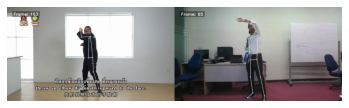

In [ ]:

case2_3_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = False,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = True)

## Unweight angle

### case 1

In [ ]:
%%capture
case1_kf(path = diff_angle,
         keyframe_dict = diff_angle_dict,
         weight = False,
         threshold = False,
         exponential = False,
         angle_cosine_func = warp_sum_angle_kf,
         kf_img = True)

### case 2&3

In [ ]:
%%capture
case2_3_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = False,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_angle_kf,
           kf_img = True)

## Weight cosine

### case 1

A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???_??????????????????_?????_cosine_similarity already exists.


95 8
124 41
165 103


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity already exists.


87 88
136 137


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???_??????????????_?????_cosine_similarity already exists.


119 1
140 146


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???_???????????_?????_cosine_similarity already exists.


178 78
222 78


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????????_???_????????????????_?????_cosine_similarity already exists.


125 93
153 132


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity already exists.


92 100
124 125


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity already exists.


118 102
145 143


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???_??????????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???_??????????????????_?????_cosine_similarity\Weight-keyframe already exists.


95 8
124 41
165 103


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???_??????????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe already exists.


87 88
136 137


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???_??????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???_??????????????_?????_cosine_similarity\Weight-keyframe already exists.


119 1
140 146


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???_??????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???_???????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???_???????????_?????_cosine_similarity\Weight-keyframe already exists.


178 78
222 78


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???_???????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????????_???_????????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????????_???_????????????????_?????_cosine_similarity\Weight-keyframe already exists.


125 93
153 132


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????????_???_????????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe already exists.


92 100
124 125


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe already exists.


118 102
145 143


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???_??????????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???_??????????????????_?????_cosine_similarity\Weight-keyframe already exists.


95 8
124 41
165 103


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???_??????????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe already exists.


87 88
136 137


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???_??????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???_??????????????_?????_cosine_similarity\Weight-keyframe already exists.


119 1
140 146


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???_??????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???_???????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???_???????????_?????_cosine_similarity\Weight-keyframe already exists.


178 78
222 78


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???_???????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????????_???_????????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????????_???_????????????????_?????_cosine_similarity\Weight-keyframe already exists.


125 93
153 132


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????????_???_????????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe already exists.


92 100
124 125


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity already exists.
A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe already exists.


118 102
145 143


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_????????????_???_????????????_?????_cosine_similarity\Weight-keyframe\kf_img already exists.


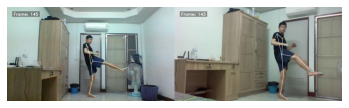

In [ ]:

case1_kf(path = diff_angle,
         keyframe_dict = diff_angle_dict,
         weight = True,
         threshold = False,
         exponential = False,
         angle_cosine_func = warp_sum_cosine_kf,
         kf_img = True)

### case 2&3


In [ ]:

case2_3_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = True,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = True)

A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_1_cosine_similarity already exists.


124 0
163 52


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_2_cosine_similarity already exists.


124 3
163 77


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_3_cosine_similarity already exists.


124 25
163 66


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_4_cosine_similarity already exists.


124 81
163 119


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????????_5_cosine_similarity already exists.


124 60
163 83
124 2
163 69


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_1_cosine_similarity already exists.


124 0
163 54


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_2_cosine_similarity already exists.


124 81
163 111


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_3_cosine_similarity already exists.


124 4
163 65


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_4_cosine_similarity already exists.


124 17
163 63


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_??????????????_5_cosine_similarity already exists.


124 0
163 52


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???????????_cosine_similarity already exists.


124 15
163 89


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???????????_1_cosine_similarity already exists.


124 36
163 96


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???????????_2_cosine_similarity already exists.


124 30
163 68


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???????????_3_cosine_similarity already exists.


124 25
163 60


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???????????_4_cosine_similarity already exists.


124 42
163 102


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_???????????_5_cosine_similarity already exists.


124 39
163 98


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????????_cosine_similarity already exists.


124 29
163 31


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????????_1_cosine_similarity already exists.


124 38
163 98


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????????_2_cosine_similarity already exists.


124 40
163 100


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????????_3_cosine_similarity already exists.


124 37
163 96


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????????_4_cosine_similarity already exists.


124 58
163 107


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????????_5_cosine_similarity already exists.


124 1
163 55


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????_cosine_similarity already exists.


124 2
163 76


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????_1_cosine_similarity already exists.


124 28
163 58


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????_2_cosine_similarity already exists.


124 34
163 65


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????_3_cosine_similarity already exists.


124 1
163 80


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????_4_cosine_similarity already exists.


124 0
163 41


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_????????????_5_cosine_similarity already exists.


124 81
163 83


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????????_2_cosine_similarity already exists.


110 61
155 142


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????????_3_cosine_similarity already exists.


110 40
155 66


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????????_4_cosine_similarity already exists.


110 29
155 104


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????????_5_cosine_similarity already exists.


110 0
155 69


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????_cosine_similarity already exists.


110 20
155 79


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????_1_cosine_similarity already exists.


110 24
155 121


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????_2_cosine_similarity already exists.


110 91
155 105


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????_3_cosine_similarity already exists.


110 29
155 51


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????_4_cosine_similarity already exists.


110 34
155 63


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_??????????????_5_cosine_similarity already exists.


110 9
155 47


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_???????????_cosine_similarity already exists.


110 26
155 101


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_???????????_1_cosine_similarity already exists.


110 106
155 108


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_???????????_2_cosine_similarity already exists.


110 28
155 68


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_???????????_3_cosine_similarity already exists.


110 23
155 65


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_???????????_4_cosine_similarity already exists.


110 44
155 116


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_???????????_5_cosine_similarity already exists.


110 0
155 103


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????????_cosine_similarity already exists.


110 40
155 131


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????????_1_cosine_similarity already exists.


110 35
155 88


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????????_2_cosine_similarity already exists.


110 38
155 123


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????????_3_cosine_similarity already exists.


110 31
155 97


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????????_4_cosine_similarity already exists.


110 35
155 129


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????????_5_cosine_similarity already exists.


110 107
155 107


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????_cosine_similarity already exists.


110 7
155 74


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????_1_cosine_similarity already exists.


110 10
155 53


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????_2_cosine_similarity already exists.


110 35
155 64


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????_3_cosine_similarity already exists.


110 30
155 82


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????_4_cosine_similarity already exists.


110 0
155 41


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_1_????????????_5_cosine_similarity already exists.


110 22
155 42


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_??????????????????_3_cosine_similarity already exists.


119 26
150 60


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_??????????????????_4_cosine_similarity already exists.


119 95
150 104


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_??????????????????_5_cosine_similarity already exists.


119 60
150 69


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_??????????????_cosine_similarity already exists.


119 2
150 68


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_??????????????_1_cosine_similarity already exists.


119 109
150 121


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_??????????????_2_cosine_similarity already exists.


119 81
150 105


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_??????????????_3_cosine_similarity already exists.


119 94
150 139


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_??????????????_4_cosine_similarity already exists.


119 96
150 106


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_??????????????_5_cosine_similarity already exists.


119 0
150 47


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_???????????_cosine_similarity already exists.


119 15
150 101


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_???????????_1_cosine_similarity already exists.


119 107
150 108


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_???????????_2_cosine_similarity already exists.


119 81
150 134


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_???????????_3_cosine_similarity already exists.


119 21
150 60


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_???????????_4_cosine_similarity already exists.


119 35
150 102


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_???????????_5_cosine_similarity already exists.


119 38
150 97


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????????_cosine_similarity already exists.


119 16
150 118


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????????_1_cosine_similarity already exists.


119 35
150 110


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????????_2_cosine_similarity already exists.


119 38
150 123


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????????_3_cosine_similarity already exists.


119 36
150 97


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????????_4_cosine_similarity already exists.


119 37
150 129


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????????_5_cosine_similarity already exists.


119 1
150 57


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????_cosine_similarity already exists.


119 3
150 74


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????_1_cosine_similarity already exists.


119 94
150 156


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????_2_cosine_similarity already exists.


119 34
150 73


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????_3_cosine_similarity already exists.


119 39
150 82


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????_4_cosine_similarity already exists.


119 1
150 43


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_2_????????????_5_cosine_similarity already exists.


119 87
150 154


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_??????????????????_4_cosine_similarity already exists.


128 86
151 104


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_??????????????????_5_cosine_similarity already exists.


128 59
151 69


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_??????????????_cosine_similarity already exists.


128 1
151 79


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_??????????????_1_cosine_similarity already exists.


128 94
151 149


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_??????????????_2_cosine_similarity already exists.


128 77
151 105


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_??????????????_3_cosine_similarity already exists.


128 113
151 139


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_??????????????_4_cosine_similarity already exists.


128 88
151 108


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_??????????????_5_cosine_similarity already exists.


128 106
151 170


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_???????????_cosine_similarity already exists.


128 16
151 101


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_???????????_1_cosine_similarity already exists.


128 109
151 109


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_???????????_2_cosine_similarity already exists.


128 90
151 134


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_???????????_3_cosine_similarity already exists.


128 30
151 60


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_???????????_4_cosine_similarity already exists.


128 47
151 122


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_???????????_5_cosine_similarity already exists.


128 47
151 98


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????????_cosine_similarity already exists.


128 53
151 140


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????????_1_cosine_similarity already exists.


128 34
151 89


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????????_2_cosine_similarity already exists.


128 54
151 123


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????????_3_cosine_similarity already exists.


128 36
151 97


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????????_4_cosine_similarity already exists.


128 44
151 129


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????????_5_cosine_similarity already exists.


128 34
151 57


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????_cosine_similarity already exists.


128 3
151 74


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????_1_cosine_similarity already exists.


128 95
151 151


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????_2_cosine_similarity already exists.


128 4
151 61


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????_3_cosine_similarity already exists.


128 36
151 82


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????_4_cosine_similarity already exists.


128 71
151 83


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_3_????????????_5_cosine_similarity already exists.


128 109
151 154


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_??????????????????_5_cosine_similarity already exists.


85 59
108 74


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_??????????????_cosine_similarity already exists.


85 1
108 69


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_??????????????_1_cosine_similarity already exists.


85 0
108 54


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_??????????????_2_cosine_similarity already exists.


85 72
108 110


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_??????????????_3_cosine_similarity already exists.


85 0
108 64


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_??????????????_4_cosine_similarity already exists.


85 17
108 63


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_??????????????_5_cosine_similarity already exists.


85 0
108 52


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_???????????_cosine_similarity already exists.


85 15
108 81


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_???????????_1_cosine_similarity already exists.


85 29
108 88


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_???????????_2_cosine_similarity already exists.


85 30
108 68


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_???????????_3_cosine_similarity already exists.


85 28
108 68


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_???????????_4_cosine_similarity already exists.


85 0
108 13


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_???????????_5_cosine_similarity already exists.


85 40
108 93


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????????_cosine_similarity already exists.


85 16
108 16


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????????_1_cosine_similarity already exists.


85 34
108 91


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????????_2_cosine_similarity already exists.


85 44
108 96


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????????_3_cosine_similarity already exists.


85 35
108 91


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????????_4_cosine_similarity already exists.


85 43
108 51


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????????_5_cosine_similarity already exists.


85 27
108 64


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????_cosine_similarity already exists.


85 2
108 74


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????_1_cosine_similarity already exists.


85 12
108 54


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????_2_cosine_similarity already exists.


85 3
108 65


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????_3_cosine_similarity already exists.


85 39
108 90


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????_4_cosine_similarity already exists.


85 74
108 84


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_4_????????????_5_cosine_similarity already exists.


85 74
108 74


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_??????????????_cosine_similarity already exists.


59 0
69 67


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_??????????????_1_cosine_similarity already exists.


59 0
69 52


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_??????????????_2_cosine_similarity already exists.


59 67
69 100


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_??????????????_3_cosine_similarity already exists.


59 4
69 67


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_??????????????_4_cosine_similarity already exists.


59 17
69 64


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_??????????????_5_cosine_similarity already exists.


59 0
69 53


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_???????????_cosine_similarity already exists.


59 15
69 23


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_???????????_1_cosine_similarity already exists.


59 29
69 31


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_???????????_2_cosine_similarity already exists.


59 30
69 68


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_???????????_3_cosine_similarity already exists.


59 29
69 67


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_???????????_4_cosine_similarity already exists.


59 4
69 41


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_???????????_5_cosine_similarity already exists.


59 39
69 39


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????????_cosine_similarity already exists.


59 16
69 16


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????????_1_cosine_similarity already exists.


59 34
69 81


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????????_2_cosine_similarity already exists.


59 39
69 86


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????????_3_cosine_similarity already exists.


59 37
69 85


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????????_4_cosine_similarity already exists.


59 43
69 46


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????????_5_cosine_similarity already exists.


59 1
69 56


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????_cosine_similarity already exists.


59 3
69 68


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????_1_cosine_similarity already exists.


59 29
69 59


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????_2_cosine_similarity already exists.


59 0
69 58


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????_3_cosine_similarity already exists.


59 1
69 66


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????_4_cosine_similarity already exists.


59 64
69 78


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????????_5_????????????_5_cosine_similarity already exists.


59 29
69 43


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_??????????????_1_cosine_similarity already exists.


160 0
194 116


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_??????????????_2_cosine_similarity already exists.


160 70
194 98


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_??????????????_3_cosine_similarity already exists.


160 116
194 132


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_??????????????_4_cosine_similarity already exists.


160 7
194 102


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_??????????????_5_cosine_similarity already exists.


160 106
194 169


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???????????_cosine_similarity already exists.


160 33
194 116


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???????????_1_cosine_similarity already exists.


160 109
194 140


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???????????_2_cosine_similarity already exists.


160 34
194 71


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???????????_3_cosine_similarity already exists.


160 35
194 60


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???????????_4_cosine_similarity already exists.


160 44
194 105


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_???????????_5_cosine_similarity already exists.


160 45
194 108


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????????_cosine_similarity already exists.


160 59
194 116


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????????_1_cosine_similarity already exists.


160 22
194 77


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????????_2_cosine_similarity already exists.


160 49
194 112


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????????_3_cosine_similarity already exists.


160 35
194 37


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????????_4_cosine_similarity already exists.


160 46
194 110


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????????_5_cosine_similarity already exists.


160 28
194 72


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????_cosine_similarity already exists.


160 7
194 37


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????_1_cosine_similarity already exists.


160 1
194 98


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????_2_cosine_similarity already exists.


160 10
194 39


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????_3_cosine_similarity already exists.


160 30
194 55


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????_4_cosine_similarity already exists.


160 74
194 129


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_????????????_5_cosine_similarity already exists.


160 115
194 137


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_??????????????_2_cosine_similarity already exists.


99 78
130 94


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_??????????????_3_cosine_similarity already exists.


99 98
130 135


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_??????????????_4_cosine_similarity already exists.


99 88
130 120


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_??????????????_5_cosine_similarity already exists.


99 94
130 94


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_???????????_cosine_similarity already exists.


99 15
130 82


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_???????????_1_cosine_similarity already exists.


99 26
130 96


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_???????????_2_cosine_similarity already exists.


99 91
130 147


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_???????????_3_cosine_similarity already exists.


99 29
130 62


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_???????????_4_cosine_similarity already exists.


99 0
130 23


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_???????????_5_cosine_similarity already exists.


99 51
130 116


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????????_cosine_similarity already exists.


99 16
130 109


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????????_1_cosine_similarity already exists.


99 34
130 79


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????????_2_cosine_similarity already exists.


99 44
130 116


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????????_3_cosine_similarity already exists.


99 37
130 86


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????????_4_cosine_similarity already exists.


99 43
130 121


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????????_5_cosine_similarity already exists.


99 1
130 11


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????_cosine_similarity already exists.


99 2
130 38


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????_1_cosine_similarity already exists.


99 93
130 100


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????_2_cosine_similarity already exists.


99 3
130 39


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????_3_cosine_similarity already exists.


99 39
130 51


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????_4_cosine_similarity already exists.


99 68
130 76


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_1_????????????_5_cosine_similarity already exists.


99 98
130 126


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_??????????????_3_cosine_similarity already exists.


147 113
178 146


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_??????????????_4_cosine_similarity already exists.


147 88
178 110


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_??????????????_5_cosine_similarity already exists.


147 107
178 181


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_???????????_cosine_similarity already exists.


147 16
178 119


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_???????????_1_cosine_similarity already exists.


147 110
178 140


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_???????????_2_cosine_similarity already exists.


147 90
178 115


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_???????????_3_cosine_similarity already exists.


147 92
178 125


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_???????????_4_cosine_similarity already exists.


147 47
178 127


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_???????????_5_cosine_similarity already exists.


147 48
178 111


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????????_cosine_similarity already exists.


147 52
178 121


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????????_1_cosine_similarity already exists.


147 122
178 175


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????????_2_cosine_similarity already exists.


147 54
178 143


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????????_3_cosine_similarity already exists.


147 120
178 120


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????????_4_cosine_similarity already exists.


147 44
178 122


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????????_5_cosine_similarity already exists.


147 35
178 52


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????_cosine_similarity already exists.


147 2
178 38


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????_1_cosine_similarity already exists.


147 93
178 101


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????_2_cosine_similarity already exists.


147 135
178 148


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????_3_cosine_similarity already exists.


147 128
178 165


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????_4_cosine_similarity already exists.


147 70
178 83


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_2_????????????_5_cosine_similarity already exists.


147 103
178 121


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_??????????????_4_cosine_similarity already exists.


121 13
140 107


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_??????????????_5_cosine_similarity already exists.


121 3
140 93


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_???????????_cosine_similarity already exists.


121 29
140 116


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_???????????_1_cosine_similarity already exists.


121 103
140 108


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_???????????_2_cosine_similarity already exists.


121 29
140 76


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_???????????_3_cosine_similarity already exists.


121 35
140 67


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_???????????_4_cosine_similarity already exists.


121 44
140 125


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_???????????_5_cosine_similarity already exists.


121 4
140 37


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????????_cosine_similarity already exists.


121 40
140 121


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????????_1_cosine_similarity already exists.


121 25
140 82


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????????_2_cosine_similarity already exists.


121 49
140 127


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????????_3_cosine_similarity already exists.


121 35
140 90


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????????_4_cosine_similarity already exists.


121 47
140 48


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????????_5_cosine_similarity already exists.


121 26
140 51


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????_cosine_similarity already exists.


121 7
140 36


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????_1_cosine_similarity already exists.


121 2
140 101


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????_2_cosine_similarity already exists.


121 10
140 21


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????_3_cosine_similarity already exists.


121 32
140 76


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????_4_cosine_similarity already exists.


121 0
140 20


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_3_????????????_5_cosine_similarity already exists.


121 18
140 31


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_??????????????_5_cosine_similarity already exists.


89 0
107 24


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_???????????_cosine_similarity already exists.


89 15
107 15


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_???????????_1_cosine_similarity already exists.


89 26
107 26


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_???????????_2_cosine_similarity already exists.


89 30
107 76


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_???????????_3_cosine_similarity already exists.


89 29
107 69


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_???????????_4_cosine_similarity already exists.


89 0
107 12


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_???????????_5_cosine_similarity already exists.


89 51
107 54


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????????_cosine_similarity already exists.


89 16
107 16


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????????_1_cosine_similarity already exists.


89 34
107 80


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????????_2_cosine_similarity already exists.


89 44
107 73


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????????_3_cosine_similarity already exists.


89 37
107 86


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????????_4_cosine_similarity already exists.


89 43
107 43


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????????_5_cosine_similarity already exists.


89 1
107 8


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????_cosine_similarity already exists.


89 2
107 3


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????_1_cosine_similarity already exists.


89 12
107 34


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????_2_cosine_similarity already exists.


89 3
107 16


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????_3_cosine_similarity already exists.


89 39
107 78


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????_4_cosine_similarity already exists.


89 65
107 75


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_4_????????????_5_cosine_similarity already exists.


89 29
107 31


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_???????????_cosine_similarity already exists.


139 47
208 147


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_???????????_1_cosine_similarity already exists.


139 37
208 103


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_???????????_2_cosine_similarity already exists.


139 38
208 127


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_???????????_3_cosine_similarity already exists.


139 37
208 37


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_???????????_4_cosine_similarity already exists.


139 73
208 151


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_???????????_5_cosine_similarity already exists.


139 68
208 160


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????????_cosine_similarity already exists.


139 82
208 160


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????????_1_cosine_similarity already exists.


139 49
208 150


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????????_2_cosine_similarity already exists.


139 75
208 160


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????????_3_cosine_similarity already exists.


139 43
208 131


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????????_4_cosine_similarity already exists.


139 60
208 141


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????????_5_cosine_similarity already exists.


139 42
208 89


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????_cosine_similarity already exists.


139 3
208 7


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????_1_cosine_similarity already exists.


139 12
208 26


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????_2_cosine_similarity already exists.


139 126
208 144


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????_3_cosine_similarity already exists.


139 1
208 1


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????_4_cosine_similarity already exists.


139 0
208 23


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_??????????????_5_????????????_5_cosine_similarity already exists.


139 117
208 132


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???????????_1_cosine_similarity already exists.


114 0
144 11


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???????????_2_cosine_similarity already exists.


114 69
144 92


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???????????_3_cosine_similarity already exists.


114 63
144 76


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???????????_4_cosine_similarity already exists.


114 22
144 36


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_???????????_5_cosine_similarity already exists.


114 22
144 41


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????????_cosine_similarity already exists.


114 0
144 31


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????????_1_cosine_similarity already exists.


114 77
144 121


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????????_2_cosine_similarity already exists.


114 7
144 45


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????????_3_cosine_similarity already exists.


114 80
144 120


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????????_4_cosine_similarity already exists.


114 33
144 36


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????????_5_cosine_similarity already exists.


114 71
144 100


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????_cosine_similarity already exists.


114 55
144 55


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????_1_cosine_similarity already exists.


114 38
144 94


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????_2_cosine_similarity already exists.


114 47
144 94


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????_3_cosine_similarity already exists.


114 79
144 123


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????_4_cosine_similarity already exists.


114 19
144 73


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_????????????_5_cosine_similarity already exists.


114 25
144 96


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_???????????_2_cosine_similarity already exists.


100 77
119 96


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_???????????_3_cosine_similarity already exists.


100 75
119 86


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_???????????_4_cosine_similarity already exists.


100 23
119 31


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_???????????_5_cosine_similarity already exists.


100 22
119 29


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????????_cosine_similarity already exists.


100 4
119 7


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????????_1_cosine_similarity already exists.


100 30
119 35


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????????_2_cosine_similarity already exists.


100 0
119 38


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????????_3_cosine_similarity already exists.


100 19
119 35


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????????_4_cosine_similarity already exists.


100 32
119 36


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????????_5_cosine_similarity already exists.


100 3
119 12


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????_cosine_similarity already exists.


100 35
119 36


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????_1_cosine_similarity already exists.


100 24
119 28


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????_2_cosine_similarity already exists.


100 36
119 38


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????_3_cosine_similarity already exists.


100 3
119 4


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????_4_cosine_similarity already exists.


100 16
119 16


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_1_????????????_5_cosine_similarity already exists.


100 17
119 83


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_2_???????????_3_cosine_similarity already exists.


75 69
101 86


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_2_???????????_4_cosine_similarity already exists.


75 23
101 23


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_2_???????????_5_cosine_similarity already exists.


75 0
101 30


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_2_????????????????_cosine_similarity already exists.


75 0
101 36


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_2_????????????????_1_cosine_similarity already exists.


75 25
101 26


A subdirectory or file C:\Users\Gear\Desktop\dtw\dtw_???????????_2_????????????????_2_cosine_similarity already exists.


75 0
101 33


## Weight angle

### case 1

In [ ]:
case1_kf(path = diff_angle,
         keyframe_dict = [],
         weight = True,
         threshold = False,
         exponential = False,
         angle_cosine_func = warp_sum_angle_kf)

### case 2&3

In [ ]:
case2_3_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = [],
           weight = True,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_angle_kf)

## Moving weight cosine

### case1

In [ ]:
for w in [30,60,90]:
    case1_kf(path = diff_angle,
            keyframe_dict = [],
            weight = 'auto',
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_cosine_kf,
            auto_method='aj',
            window=w)

### case 2&3

In [ ]:
for w in [30,60,90]:
    case2_3_kf(path1 = friends_video,
            path2 = friends_video,
            keyframe_dict = [],
            weight = 'auto',
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_cosine_kf,
            auto_method='aj',
            window=w)

## Moving weight angle

### case 1

In [ ]:
for w in [30,60,90]:
    case1_kf(path = diff_angle,
            keyframe_dict = [],
            weight = 'auto',
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_angle_kf,
            auto_method='aj',
            window=w)

### case 2&3

In [ ]:
for w in [30,60,90]:
    case2_3_kf(path1 = friends_video,
            path2 = friends_video,
            keyframe_dict = [],
            weight = 'auto',
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_angle_kf,
            auto_method='aj',
            window=w)